# Analysis

## 1. Imports

In [1]:
import json
import pandas as pd
from tqdm import tqdm
from rdkit import RDLogger

from utils.answer_verifier import AnswerVerifier
from utils import parser

RDLogger.DisableLog('rdApp.*')
tqdm.pandas()

## 2. Check answers

In [2]:
# Load model responses
df = pd.read_csv('model_responses/combined_model_responses.csv')

# Parse responses using algorithmic parser
answer_parser = parser.AnswerParser("questions/chemiq.jsonl", doClean=True)
df["parsed_answer"] = df.apply(lambda row: answer_parser.parse(row["uuid"], row["raw_model_answer"]), axis=1)

# Check answers using the AnswerVerifier script
answer_checker = AnswerVerifier("questions/chemiq.jsonl")
df[['is_correct','opsin_smiles']] = (df.progress_apply(lambda row: pd.Series(answer_checker.check_answer(row["uuid"], row["parsed_answer"])),axis=1))

100%|██████████████████████████████████████████████████████████████████| 13872/13872 [00:04<00:00, 3408.56it/s]


## 3. Check answers without answer parser
- Also add questions columns for data analysis

In [3]:
# Read responses from the models without algorithmic answer parsing
raw_parser = parser.AnswerParser("questions/chemiq.jsonl", doClean=False)
df["raw_parsed_answer"] = df.apply(lambda row: raw_parser.parse(row["uuid"], row["raw_model_answer"]), axis=1)
df[['raw_is_correct','raw_opsin_smiles']] = (df.progress_apply(lambda row: pd.Series(answer_checker.check_answer(row["uuid"], row["raw_parsed_answer"])),axis=1))

# Add question data columns to dataframe for easier analysis
all_questions = []
with open("questions/chemiq.jsonl", 'r') as f:
    for line in f:
        all_questions.append(json.loads(line))
question_dict = {q["uuid"]: q for q in all_questions}

# Add useful question columns to dataframe
df["question_category"] = df["uuid"].apply(lambda x: question_dict[x]["question_category"])
df["sub_category"] = df["uuid"].apply(lambda x: question_dict[x]["sub_category"])
df["expected_answer"] = df["uuid"].apply(lambda x: question_dict[x]["answer"])

# Making this column integers when possible helps with plotting later
df['thinking_budget'] = df['thinking_budget'].apply(lambda x: int(x) if isinstance(x, str) and x.isdigit() else x)

# For consistency I am setting the reasoning token column to the output tokens column. 
df["output_tokens"] = df["total_tokens"] - df["prompt_tokens"]
df["reasoning_tokens"] = df["output_tokens"]

100%|██████████████████████████████████████████████████████████████████| 13872/13872 [00:04<00:00, 3442.94it/s]


# Plot results

/tmp/ipykernel_1552547/2035795933.py:35: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pv = df[df[category_col].isin([l, r])].pivot(index="uuid",
/tmp/ipykernel_1552547/2035795933.py:35: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pv = df[df[category_col].isin([l, r])].pivot(index="uuid",
/tmp/ipykernel_1552547/2035795933.py:35: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pv = df[df[category_col].isin([l, r])].pivot(index="uuid",
/tmp/ipykernel_1552547/2035795933.py:35: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pv = df[df[category_col].isin([l, r])].pivot(index=

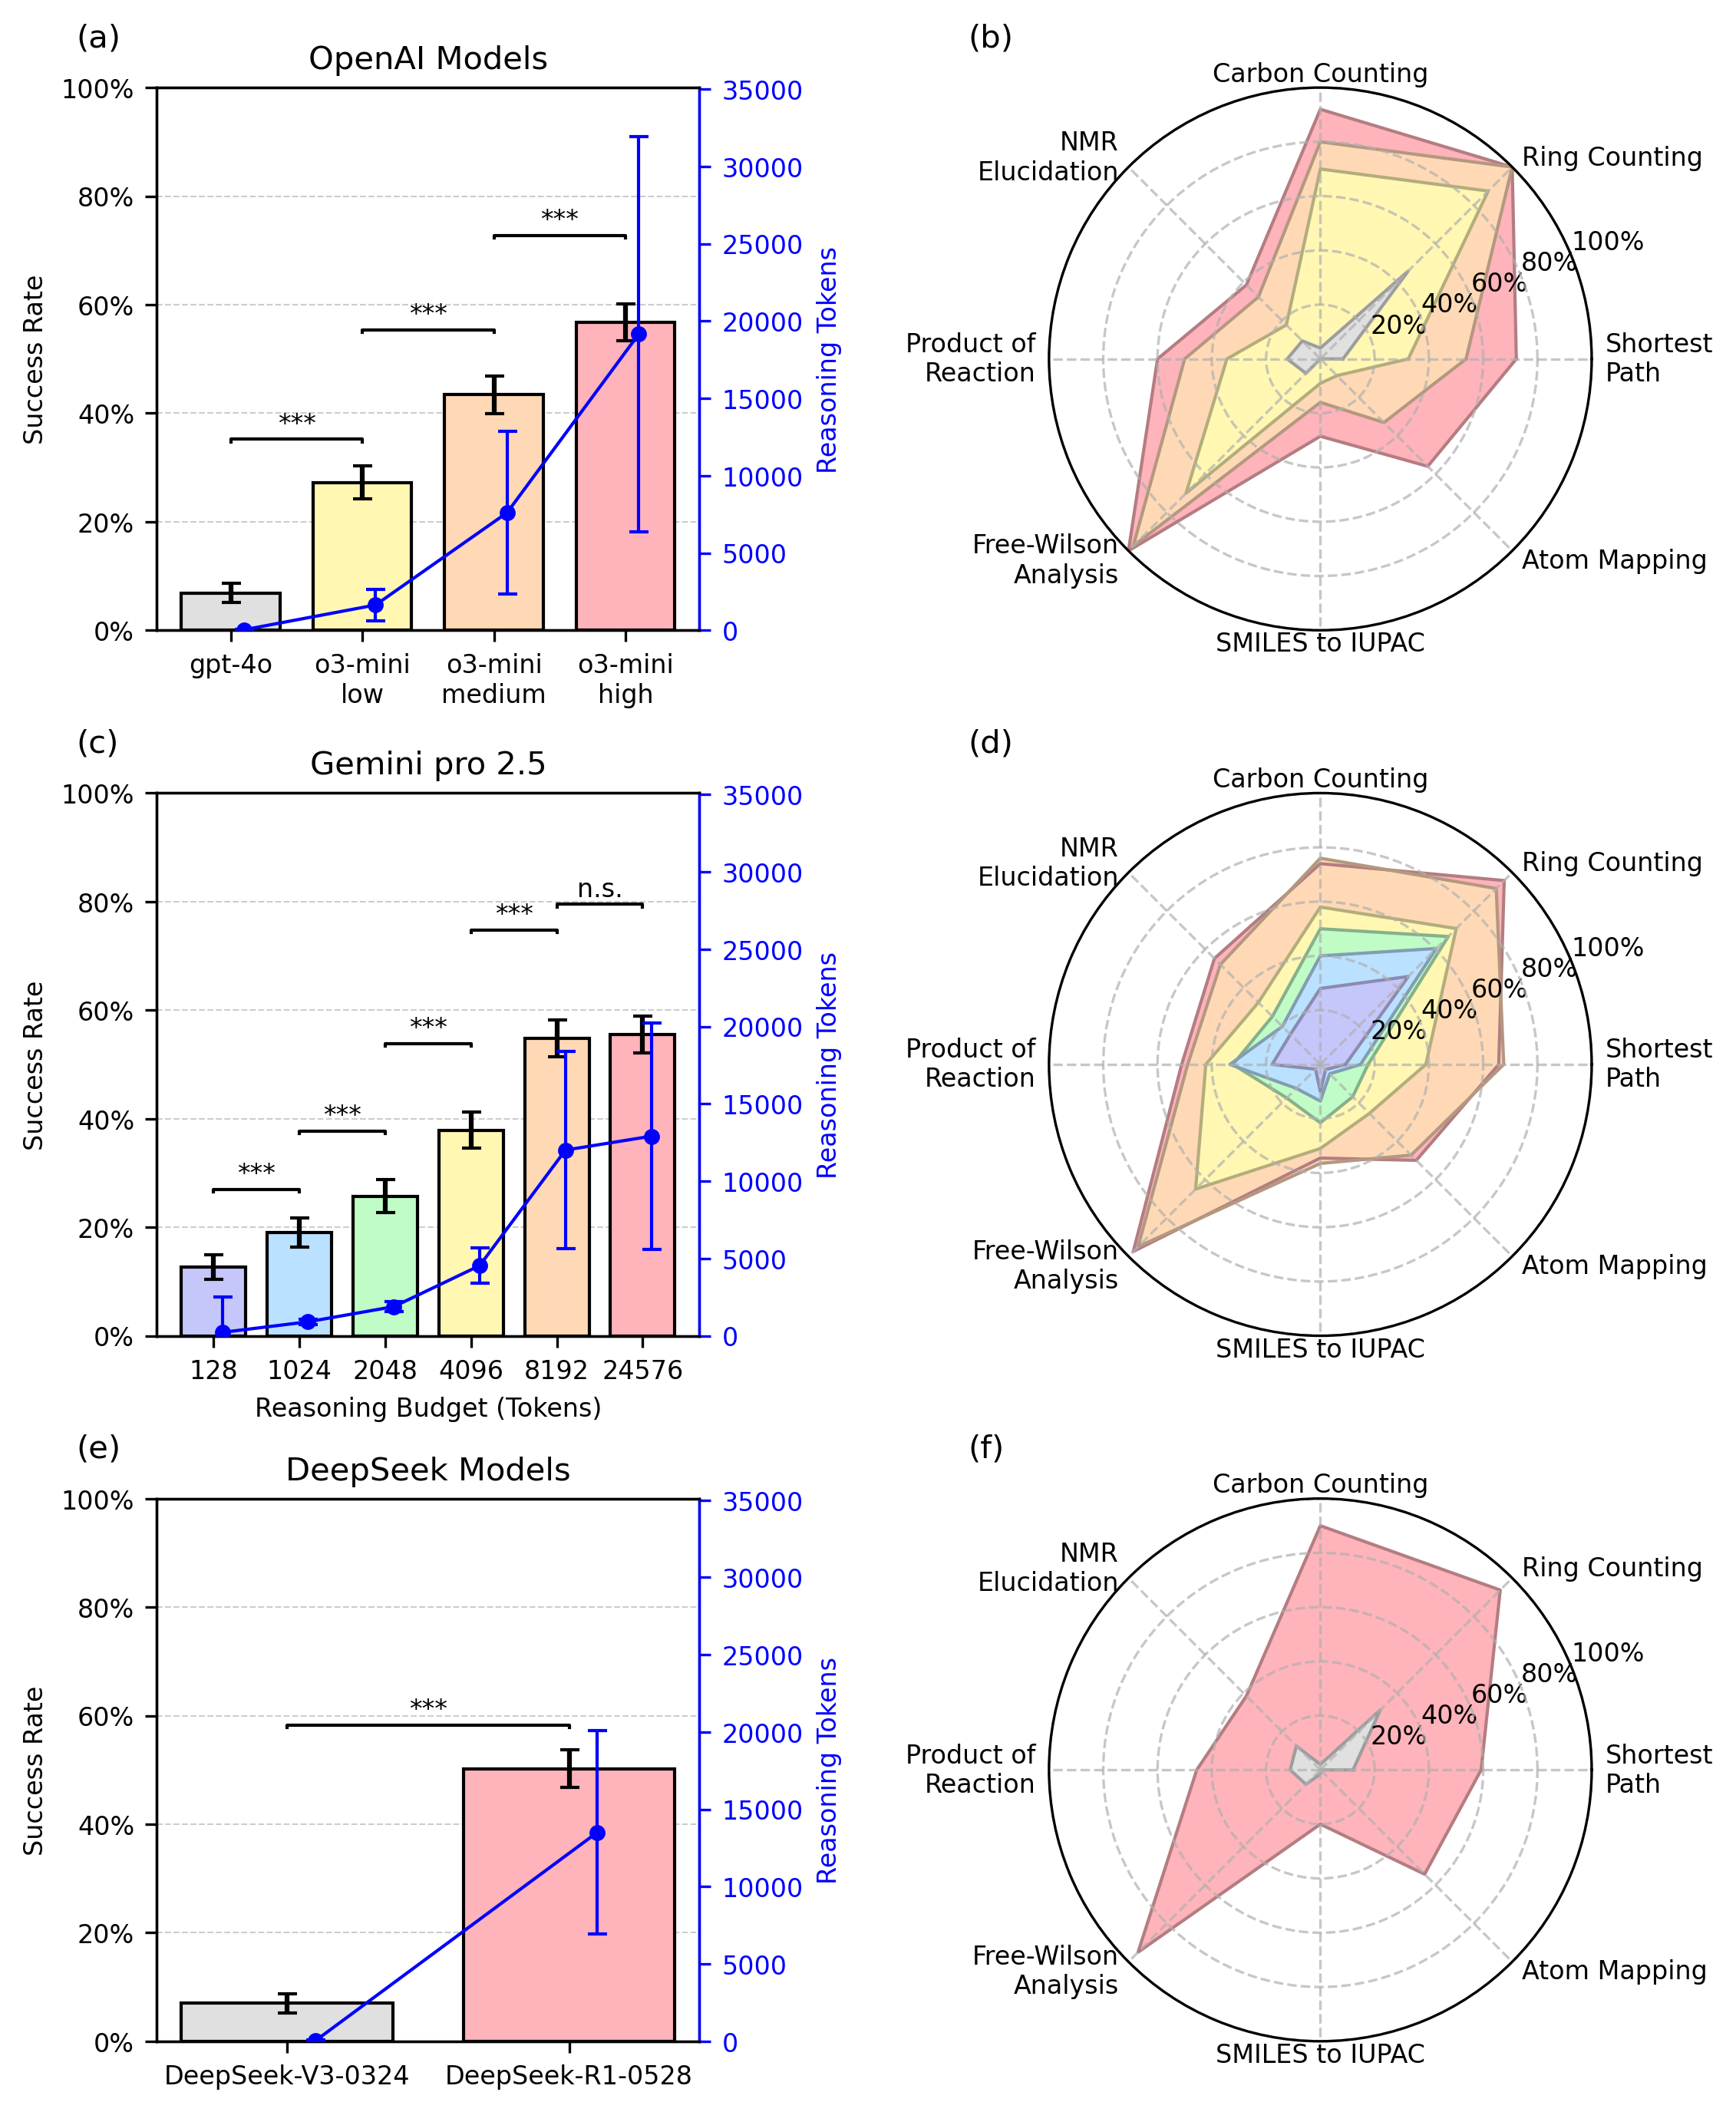

In [19]:
#!/usr/bin/env python3
"""
Combined figure: for each model group a radar plot (left) and the matching
bar + token-line plot (right), stacked in four rows.
Assumes a pandas DataFrame **df** already in memory.
"""

from __future__ import annotations
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib.ticker as mtick
import matplotlib.patches as mpatches, matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from scipy.stats import binomtest
try:
    from statsmodels.stats.contingency import mcnemar as sm_mcnemar
except ImportError:
    sm_mcnemar = None

# ───────────────────────────────────────────────────────────
#  Shared helpers (copied verbatim from the two source files)
# ───────────────────────────────────────────────────────────

def mcnemar_one_sided(b, c):
    n = b + c
    if n == 0: return 1.0
    if sm_mcnemar is not None:
        p_two = sm_mcnemar([[0, b], [c, 0]], exact=True).pvalue
        return p_two / 2 if c > b else 1.0
    return binomtest(c, n=n, alternative="greater").pvalue

def p_to_stars(p): return "***" if p < .001 else "**" if p < .01 else "*" if p < .05 else "n.s."

def mcnemar_adjacent_pvals(df, category_col, ordered):
    pvals = []
    for l, r in zip(ordered[:-1], ordered[1:]):
        pv = df[df[category_col].isin([l, r])].pivot(index="uuid",
                                                     columns=category_col,
                                                     values="is_correct").dropna()
        if pv.empty:
            pvals.append(1.0); continue
        b = ((pv[l]==1)&(pv[r]==0)).sum()
        c = ((pv[l]==0)&(pv[r]==1)).sum()
        pvals.append(mcnemar_one_sided(b, c))
    return pvals

def add_significance_brackets(ax, bar_x, perf, pvals, bar_w=.75,
                              base_offset=.08, step=.04):
    for i, p in enumerate(pvals):
        x1, x2 = bar_x[i], bar_x[i+1]
        y = max(perf[i], perf[i+1]) + base_offset + i*step
        ax.plot([x1,x1,x2,x2], [y-.005,y,y,y-.005], color="black",
                lw=1, zorder=6)
        ax.text((x1+x2)/2, y+.005, p_to_stars(p), ha="center",
                va="bottom", fontsize=8, zorder=6)



# ───────────────────────────────────────────────────────────
#  BAR-/TOKEN PLOT UTILITIES  (unchanged)
# ───────────────────────────────────────────────────────────
def calc_numeric(df_subset):
    df = df_subset.copy(); df["thinking_budget"] = df["thinking_budget"].astype(int)
    budgets = sorted(df["thinking_budget"].unique())
    n   = df["uuid"].nunique()
    perf = df.groupby("thinking_budget")["is_correct"].mean().reindex(budgets)
    ci   = np.sqrt(perf*(1-perf)/n)*1.96
    avg  = df.groupby("thinking_budget")["reasoning_tokens"].mean().reindex(budgets)
    std  = df.groupby("thinking_budget")["reasoning_tokens"].std().reindex(budgets).fillna(0)
    return budgets, perf.values, ci.values, avg.values, std.values

def _orig_plot_bars(ax, x, perf, ci, avg, std, labels, colors,
              pvals=None, tok_max=None, *, show_tok_ylabel=False,
              bar_w=.75, offset=.1):
    ax.bar(x, perf, width=bar_w, color=colors, edgecolor="black", zorder=3)
    ax.errorbar(x, perf, yerr=ci, fmt="none", capsize=3, ecolor="black", zorder=4)
    ax.set_xticks(x); ax.set_xticklabels(labels, fontsize=8)
    ax.set_ylim(0,1); ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    ax.tick_params(axis="x", labelsize=8)
    ax.tick_params(axis="y", labelsize=8)

    
    for y in np.arange(.2,1,.2): ax.axhline(y, ls="--", lw=.5, color="grey",
                                            alpha=.4, zorder=1)
    ax2 = ax.twinx()
    ax2.errorbar(x+offset, avg, yerr=std, marker="o", ms=4, lw=1,
                 capsize=3, color="blue", zorder=5)
    ax2.set_ylim(0, tok_max); ax2.tick_params(axis="y", colors="blue")
    ax2.spines["right"].set_color("blue")
    ax2.tick_params(axis="y", labelsize=8)
    if not show_tok_ylabel: ax2.set_yticklabels([])
    else: ax2.set_ylabel("Reasoning Tokens", color="blue", fontsize=8)
    if pvals: add_significance_brackets(ax, x, perf, pvals, bar_w)

def plot_bars(ax, *args, **kwargs):
    _orig_plot_bars(ax, *args, **kwargs)   # <- your original function (renamed)
    ax.set_box_aspect(1)   

# ───────────────────────────────────────────────────────────
#  RADAR-PLOT UTILITIES  (unchanged)
# ───────────────────────────────────────────────────────────
question_order = ["shortest_path","counting_ring","counting_carbon",
                  "nmr_elucidation","reaction","sar",
                  "smiles_to_iupac","atom_mapping"]
question_labels = {
    "counting_carbon":"Carbon Counting","counting_ring":"Ring Counting",
    "sar":"Free-Wilson\nAnalysis","shortest_path":"Shortest\nPath",
    "atom_mapping":"Atom Mapping","smiles_to_iupac":"SMILES to IUPAC",
    "reaction":"Product of\nReaction","nmr_elucidation":"NMR\nElucidation",
}
def darken(col,f=.7): rgb=np.array(mcolors.to_rgb(col));return tuple(np.clip(rgb*f,0,1))
def success_rates(base, grp, correct_col="is_correct"):
    """Per–question success rate of *grp* relative to the denominator *base*.
    
    Parameters
    ----------
    base        DataFrame holding the full denominator (usually the whole subset).
    grp         DataFrame holding only the rows to be evaluated.
    correct_col Which Boolean column encodes correctness (default: "is_correct").
    """
    rates = []
    for q in question_order:
        if q == "smiles_to_iupac":
            base_mask = (base["question_category"]=="smiles_to_iupac") & (
                        base["sub_category"].isin(["zinc_canonical","zinc_random"]))
            grp_mask  = (grp ["question_category"]=="smiles_to_iupac") & (
                        grp ["sub_category"].isin(["zinc_canonical","zinc_random"]))
        else:
            base_mask = base["question_category"] == q
            grp_mask  = grp ["question_category"] == q
        denom = base.loc[base_mask, "uuid"].nunique()
        num   = grp .loc[grp_mask, correct_col].sum()
        rates.append(num/denom if denom else 0)
    return rates

def beautify_axis(ax, show_xt=False):
    N = len(question_order)
    label_angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    ax.set_xticks(label_angles)
    ax.set_xticklabels([])

    if show_xt:
        offset_r = 1.05
        for txt, ang in zip(question_order, label_angles):
            lbl = question_labels.get(txt, txt)
            deg = np.degrees(ang)
            ha  = "right" if 90 < deg < 270 else \
                 ("center" if deg in (90, 270) else "left")
            ax.text(ang, offset_r, lbl, ha=ha, va="center", fontsize=8)
            
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["20%", "40%", "60%", "80%", "100%"], fontsize=8)

    for gl in ax.get_xgridlines() + ax.get_ygridlines():
        gl.set_linestyle("--")
        gl.set_alpha(0.7)

    
        
def plot_radar(ax, subset_df, keys, lookup, colour_for):
    """Draw a radar with bottom-left legend & full tick-labels."""
    handles = []
    for key in reversed(keys):
        grp  = lookup(key)
        vals = np.asarray(success_rates(subset_df, grp))
        ang  = np.linspace(0, 2*np.pi, len(vals), endpoint=False)
        # close the loop
        vals = np.r_[vals, vals[0]]
        ang  = np.r_[ang,  ang[0]]

        base = colour_for(key)
        ax.fill(ang, vals, fc=base, ec=None, alpha=1, zorder=0)
        ax.plot(ang, vals, lw=1, color=darken(base), zorder=1)
        handles.append(mpatches.Patch(fc=base, ec="black", label=str(key)))

    beautify_axis(ax, show_xt=True)        # ← always show the labels
    # ax.legend(handles=handles[::-1],
    #           loc="lower left",
    #           bbox_to_anchor=(-0.05, -0.10),
    #           fontsize=8,
    #           frameon=True)

def _pick_colour(label): return budget_colors.get(label, pastel["red"])
    

# pride-flag palette + overrides (identical to originals)
pastel  = {"violet":"#E2C6FF","indigo":"#C5C6FA","blue":"#BAE1FF",
           "green":"#BFFCC6","yellow":"#FFF7B2","orange":"#FFD9B5",
           "red":"#FFB3BA"}
_budget_levels = [0,128,1024,2048,4096,8192,24576]
_pride_order   = ["violet","indigo","blue","green","yellow","orange","red"]
budget_colors = {lvl: pastel[col] for lvl,col in zip(_budget_levels,_pride_order)}
budget_colors.update({
    "low":pastel["yellow"],"medium":pastel["orange"],"high":pastel["red"],
    "o3-mini-low":pastel["yellow"],"o3-mini-medium":pastel["orange"],
    "o3-mini-high":pastel["red"],
    "gpt-4o":"#e0e0e0","DeepSeek-V3-0324":"#e0e0e0",
    "DeepSeek-R1-0528":pastel["red"],
})



# ───────────────────────────────────────────────────────────
#  PRE-COMPUTE ALL FOUR GROUPS  (unchanged logic)
# ───────────────────────────────────────────────────────────
# 1) gemini-pro-2-5
gp_df = df[(df["model"]=="gemini-pro-2-5")&(df["thinking_budget"]!=32768)]
gp_keys=sorted(gp_df["thinking_budget"].astype(int).unique())
gp_lookup=lambda b: gp_df[gp_df["thinking_budget"]==b]
gp_max=max(gp_keys); gp_colour=lambda b: pastel["red"] if b==gp_max else _pick_colour(b)
bp_gp, pp_gp, ci_gp, avg_gp, sd_gp = calc_numeric(gp_df)
pv_gp=mcnemar_adjacent_pvals(gp_df,"thinking_budget",bp_gp)
col_gp=[gp_colour(b) for b in bp_gp]

# 2) gemini-flash-2-5
gf_df=df[df["model"]=="gemini-flash-2-5"]
gf_keys=sorted(gf_df["thinking_budget"].astype(int).unique())
gf_lookup=lambda b: gf_df[gf_df["thinking_budget"]==b]
gf_max=max(gf_keys)
def gf_colour(b):
    if b==gf_max: return pastel["red"]
    if b==0: return "#e0e0e0"
    if b==1024: return pastel["yellow"]
    return _pick_colour(b)
bp_gf, pp_gf, ci_gf, avg_gf, sd_gf = calc_numeric(gf_df)
pv_gf=mcnemar_adjacent_pvals(gf_df,"thinking_budget",bp_gf)
col_gf=[gf_colour(b) for b in bp_gf]

# 3) DeepSeek
ds_models=["DeepSeek-V3-0324","DeepSeek-R1-0528"]
ds_df=df[df["model"].isin(ds_models)]
ds_lookup=lambda m: ds_df[ds_df["model"]==m]
col_ds=[_pick_colour(m) for m in ds_models]
n_ds=ds_df["uuid"].nunique()
perf_ds=ds_df.groupby("model")["is_correct"].mean().reindex(ds_models)
ci_ds=np.sqrt(perf_ds*(1-perf_ds)/n_ds)*1.96
avg_ds=ds_df.groupby("model")["reasoning_tokens"].mean().reindex(ds_models)
sd_ds =ds_df.groupby("model")["reasoning_tokens"].std().reindex(ds_models).fillna(0)
pv_ds=mcnemar_adjacent_pvals(ds_df,"model",ds_models)

ds_df = df[df["model"].isin(["DeepSeek-V3-0324", "DeepSeek-R1-0528"])]  # Filter for DeepSeek models
ds_keys = sorted(ds_df["model"].unique())[::-1]  # Define group keys for DeepSeek models
ds_lookup = lambda m: ds_df[ds_df["model"] == m]  # Lookup function for DeepSeek

# 4) OpenAI gpt-4o & o3-mini
gpt_df = df[df["model"]=="gpt-4o-2024-11-20"].copy()
gpt_df[["label","order"]] = ["gpt-4o", 0]

o3_df  = df[df["model"]=="o3-mini-2025-01-31"].copy()
o3_df[["label","order"]] = (
        o3_df["thinking_budget"]
        .map({"low":    ("o3-mini-low",    1),
              "medium": ("o3-mini-medium", 2),
              "high":   ("o3-mini-high",   3)})
        .apply(pd.Series)
)

j_df   = pd.concat([gpt_df, o3_df])
order  = (j_df[["label","order"]]
          .drop_duplicates()
          .sort_values("order")["label"]
          .tolist())

pretty_labels = ["gpt-4o",
                 "o3-mini\nlow",
                 "o3-mini\nmedium",
                 "o3-mini\nhigh"]          # ← bar-axis only

col_j = [_pick_colour(k) for k in order]
mo_df = j_df.copy()
mo_lookup  = lambda k: mo_df[mo_df["label"] == k]
mo_colour  = lambda k: _pick_colour(k)
mo_keys    = order


# Group by label and compute necessary statistics
grp_j = j_df.groupby("label")
perf_j = grp_j["is_correct"].mean().reindex(order)
ci_j = np.sqrt(perf_j * (1 - perf_j) / j_df["uuid"].nunique()) * 1.96
avg_j = grp_j["reasoning_tokens"].mean().reindex(order)
sd_j = grp_j["reasoning_tokens"].std().reindex(order).fillna(0)

# McNemar p-values for adjacent groups
pv_j = mcnemar_adjacent_pvals(j_df, "label", order)
colors_j = [_pick_colour("gpt-4o"),
            _pick_colour("low"),
            _pick_colour("medium"),
            _pick_colour("high")]



# Shared token-axis limit
tok_max=1.1*np.nanmax(np.concatenate([avg_gp+sd_gp,avg_gf+sd_gf,
                                      avg_ds+sd_ds,avg_j+sd_j]))

# ───────────────────────────────────────────────────────────
#  BUILD COMBINED FIGURE
# ───────────────────────────────────────────────────────────
fig = plt.figure(figsize=(10,15), dpi=300)
gs = gridspec.GridSpec(4, 2, figure=fig,
                       width_ratios=[1, 1], height_ratios=[1, 1, 1, 1],
                       hspace=.3, wspace=.0)

# Row 0 ─────────────────────────────
ax_b0 = fig.add_subplot(gs[0, 0])
ax_r0 = fig.add_subplot(gs[0, 1], projection="polar")
plot_bars(ax_b0,
          np.arange(len(order)),
          perf_j.values, ci_j.values, avg_j.values, sd_j.values,
          labels=pretty_labels, colors=col_j,
          pvals=pv_j, tok_max=tok_max, show_tok_ylabel=True)
plot_radar(ax_r0, mo_df, mo_keys, mo_lookup, mo_colour)
# ax_b0.set_xlabel("OpenAI models", fontsize=8)
ax_b0.set_title("OpenAI Models", fontsize=10)

# Row 2 ─────────────────────────────
ax_b2 = fig.add_subplot(gs[1, 0])
ax_r2 = fig.add_subplot(gs[1, 1], projection="polar")
plot_bars(ax_b2,
          np.arange(len(bp_gp)),
          pp_gp, ci_gp, avg_gp, sd_gp,
          labels=[str(b) for b in bp_gp], colors=col_gp,
          pvals=pv_gp, tok_max=tok_max, show_tok_ylabel=True)
plot_radar(ax_r2, gp_df, gp_keys, gp_lookup, gp_colour)
ax_b2.set_xlabel("Reasoning Budget (Tokens)", fontsize=8)
ax_b2.set_title("Gemini pro 2.5", fontsize=10)

# Row 1 ─────────────────────────────

# ─────────────────────────────────────────────────────────────


ax_b1 = fig.add_subplot(gs[2, 0])
ax_r1 = fig.add_subplot(gs[2, 1], projection="polar")
plot_bars(ax_b1,
          np.arange(len(ds_models)),
          perf_ds.values, ci_ds.values, avg_ds.values, sd_ds.values,
          labels=["DeepSeek-V3-0324", "DeepSeek-R1-0528"], colors=col_ds,
          pvals=pv_ds, tok_max=tok_max, show_tok_ylabel=True)
plot_radar(ax_r1, ds_df, ds_models, ds_lookup, lambda m: _pick_colour(m))
ax_b1.set_title("DeepSeek Models", fontsize=10)
# ax_b1.set_xlabel("DeepSeek models", fontsize=8)

# Shared y-labels
for ax in (ax_b0, ax_b1, ax_b2): ax.set_ylabel("Success Rate", fontsize=8)

# Add subplot labels a–g outside the plots
labels = ['a', 'b', 'c', 'd', 'e', 'f']
axes  = [ax_b0, ax_r0, ax_b2, ax_r2, ax_b1, ax_r1]

for ax, label in zip(axes, labels):
    fig.text(ax.get_position().x0 - 0.035, 
             ax.get_position().y1 + 0.01, 
             f"({label})", 
             fontsize=10, ha="left", va="bottom")


plt.tight_layout()
#plt.savefig("figures/combined_radar_bar_grid_updated.png", bbox_inches="tight")
plt.show()

# LaTeX Tables

In [5]:
from utils import latex_helper


gp_df = df[(df["model"]=="gemini-pro-2-5")]
gp_keys=sorted(gp_df["thinking_budget"].astype(int).unique())
gp_lookup=lambda b: gp_df[gp_df["thinking_budget"]==b]
gp_max=max(gp_keys); gp_colour=lambda b: pastel["red"] if b==gp_max else _pick_colour(b)
bp_gp, pp_gp, ci_gp, avg_gp, sd_gp = calc_numeric(gp_df)
pv_gp=mcnemar_adjacent_pvals(gp_df,"thinking_budget",bp_gp)
col_gp=[gp_colour(b) for b in bp_gp]

# Now, ensuring DeepSeek data is properly passed and handled.

category_order = [
    ("counting_carbon",  ["counting"]),
    ("counting_ring",    ["counting"]),
    ("shortest_path",    ["canonical", "random"]),
    ("atom_mapping",     ["semi-canonical", "random"]),
    ("smiles_to_iupac",  ["zinc_canonical", "zinc_random"]),
    ("sar",              ["integer", "noise"]),
    ("reaction",         ["canonical", "random"]),
    ("nmr_elucidation",  ["small", "zinc_2d"]),
]

question_order = [cat for cat, _ in category_order]
sub_order      = {cat: subs for cat, subs in category_order}


# 1) ChatGPT
latex_helper.panel_table_latex(
    mo_df, mo_keys, mo_lookup,
    title="ChatGPT GPT-4o vs o3-mini",
    question_order=question_order,
    sub_order=sub_order,
    label="tab:ChatGPT-results-table",
    caption="Success rates (%) for OpenAI models on the ChemIQ benchmark. GPT-4o is a non reasoning model; o3-mini is a reasoning model with low, medium, and high indicating the thinking budget for the model.",
)

print("\n")  # New line for better readability

# 2) Gemini Pro
latex_helper.panel_table_latex(
    gp_df, gp_keys, gp_lookup,
    title="Gemini Pro 2.5",
    question_order=question_order,
    sub_order=sub_order,
    label="tab:gemini-pro-results-table",
    caption="Success rates (%) for Google Gemini Pro 2.5 on the ChemIQ benchmark. Gemini Pro 2.5 is a reasoning model; header is the thinking budget used for the model run.",
)




print("\n")  # New line for better readability


# 1) Define a new key for the raw baseline
raw_key      = "DeepSeek-R1-raw"
ds_keys_plus = ["DeepSeek-V3-0324", raw_key, "DeepSeek-R1-0528"]

# 2) Extended lookup:
def ds_lookup_plus(k: str) -> pd.DataFrame:
    """Return the correct DataFrame for any of the 3 DeepSeek keys."""
    if k == raw_key:                                   # ← NEW branch
        df_raw = ds_df[ds_df["model"] == "DeepSeek-R1-0528"].copy()
        # overwrite the column that panel_table_latex expects
        df_raw["is_correct"] = df_raw["raw_is_correct"]
        return df_raw
    else:                                              # existing behaviour
        return ds_lookup(k)

# 3) Generate the success-rate table (percentages)  ︙
latex_helper.panel_table_latex(
    ds_df,                        # unchanged ‘subset’ (denominator)
    ds_keys_plus,                 # <- 3 columns now
    ds_lookup_plus,               # <- smart lookup
    title="DeepSeek Models",
    question_order=question_order,
    sub_order=sub_order,
    label="tab:deepseek-success-table",
    caption=("Success rates (%) for DeepSeek models on the ChemIQ benchmark. DeepSeek-V3-0324 is a non-reasoning model and DeepSeek-R1-0528 is a reasoning model. DeepSeek-R1-Raw is the model performance without parsing of the answer from the output, whereas the DeepSeek-R1-0528 column is the result following algorithmic parsing of the answer from the output text."),
)


print("\n")  # New line for better readability

# 3) Gemini Flash
latex_helper.panel_table_latex(
    gf_df, gf_keys, gf_lookup,
    title="Gemini Flash 2.5",
    question_order=question_order,
    sub_order=sub_order,
    label="tab:gemini-flash-results-table",
    caption="Success rates (%) for Google Gemini Flash 2.5 on the ChemIQ benchmark. Gemini Flash 2.5 is a hybrid model capable of both non-reasoning and reasoning modes. Header is the thinking budget used for the model run: a thinking budget of 0 means the model was run in the non-reasoning mode",
)



\begin{table}[H]
\centering
\caption{Success rates (\%) for OpenAI models on the ChemIQ benchmark. GPT-4o is a non reasoning model; o3-mini is a reasoning model with low, medium, and high indicating the thinking budget for the model.}
\label{tab:ChatGPT-results-table}
\begin{tabular}{>{\raggedright\arraybackslash}p{4cm} r r r r}
\toprule
\textbf{Category} & gpt-4o & o3-mini-low & o3-mini-medium & o3-mini-high \\
\midrule
counting\_carbon\\\hspace{1em}counting (n=50) &   4.0\ &  70.0\ &  80.0\ &  92.0\ \\
\midrule
counting\_ring\\\hspace{1em}counting (n=48) &  45.8\ &  87.5\ & 100.0\ & 100.0\ \\
\midrule
shortest\_path\\\hspace{1em}canonical (n=54) &  11.1\ &  40.7\ &  70.4\ &  88.9\ \\
\hspace{1em}random (n=54) &   5.6\ &  24.1\ &  37.0\ &  55.6\ \\
\midrule
atom\_mapping\\\hspace{1em}semi-canonical (n=92) &   0.0\ &  12.0\ &  39.1\ &  62.0\ \\
\hspace{1em}random (n=92) &   0.0\ &   5.4\ &  27.2\ &  50.0\ \\
\midrule
smiles\_to\_iupac\\\hspace{1em}zinc\_canonical (n=100) &   0.0\ &  10

/tmp/ipykernel_1552547/856699229.py:35: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pv = df[df[category_col].isin([l, r])].pivot(index="uuid",
/tmp/ipykernel_1552547/856699229.py:35: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pv = df[df[category_col].isin([l, r])].pivot(index="uuid",
/tmp/ipykernel_1552547/856699229.py:35: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pv = df[df[category_col].isin([l, r])].pivot(index="uuid",
/tmp/ipykernel_1552547/856699229.py:35: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pv = df[df[category_col].isin([l, r])].pivot(index="uui

In [6]:
import pandas as pd

# 1) ChatGPT
latex_helper.panel_tokens_table_latex(
    mo_df, mo_keys, mo_lookup,
    title="ChatGPT GPT-4o vs o3-mini",
    question_order=question_order,
    sub_order=sub_order,
    label="tab:ChatGPT-token-table",
    caption="Total output tokens for OpenAI models on the ChemIQ benchmark. GPT-4o is a non reasoning model; o3-mini is a reasoning model with low, medium, and high indicating the thinking budget for the model.",
)

print("\n")  # New line for better readability

# 2) Gemini Pro
latex_helper.panel_tokens_table_latex(
    gp_df, gp_keys, gp_lookup,
    title="Gemini Pro 2.5",
    question_order=question_order,
    sub_order=sub_order,
    label="tab:gemini-pro-token-table",
    caption="Total output tokens for Google Gemini Pro 2.5 on the ChemIQ benchmark. Gemini Pro 2.5 is a reasoning model; header is the thinking budget used for the model run.",
)



print("\n")  # New line for better readability

# 4) DeepSeek
latex_helper.panel_tokens_table_latex(
    ds_df, ds_keys, ds_lookup,  # Ensure ds_df, ds_keys, ds_lookup are correctly defined
    title="DeepSeek Models",
    question_order=question_order,
    sub_order=sub_order,
    label="tab:deepseek-token-table",
    caption="Total output tokens for DeepSeek models on the ChemIQ benchmark. DeepSeek-V3-0324 is a non-reasoning model and DeepSeek-R1-0528 is a reasoning model.",
)


print("\n")  # New line for better readability

# 3) Gemini Flash
latex_helper.panel_tokens_table_latex(
    gf_df, gf_keys, gf_lookup,
    title="Gemini Flash 2.5",
    question_order=question_order,
    sub_order=sub_order,
    label="tab:gemini-flash-token-table",
    caption="Total output tokens for Google Gemini Flash 2.5 on the ChemIQ benchmark. Gemini Flash 2.5 is a hybrid model capable of both non-reasoning and reasoning modes. Header is the thinking budget used for the model run: a thinking budget of 0 means the model was run in the non-reasoning mode.",
)


                                                                                                                                               

\begin{table}[H]
\centering
\caption{Total output tokens for OpenAI models on the ChemIQ benchmark. GPT-4o is a non reasoning model; o3-mini is a reasoning model with low, medium, and high indicating the thinking budget for the model.}
\label{tab:ChatGPT-token-table}
\begin{tabular}{>{\raggedright\arraybackslash}p{4cm} r r r r}
\toprule
\textbf{Category} & gpt-4o & o3-mini-low & o3-mini-medium & o3-mini-high \\
\midrule
counting\_carbon\\\hspace{1em}counting (n=50) &   2.0 & 1582.4 & 4506.2 & 10209.9 \\
\midrule
counting\_ring\\\hspace{1em}counting (n=48) &   2.0 & 658.3 & 2725.1 & 8258.7 \\
\midrule
shortest\_path\\\hspace{1em}canonical (n=54) &   2.0 & 1748.4 & 4339.4 & 10348.5 \\
\hspace{1em}random (n=54) &   2.0 & 2171.6 & 6530.8 & 15697.8 \\
\midrule
atom\_mapping\\\hspace{1em}semi-canonical (n=92) &  83.2 & 1988.5 & 12344.5 & 27165.8 \\
\hspace{1em}random (n=92) &  85.5 & 1530.2 & 14690.3 & 35599.1 \\
\midrule
smiles\_to\_iupac\\\hspace{1em}zinc\_canonical (n=100) &  33.1 & 1690.

# Shortest path and atom mapping

/tmp/ipykernel_1534665/2199987997.py:152: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  left_ax.set_yticklabels(ax.get_yticks(), fontsize=10)
/tmp/ipykernel_1534665/2199987997.py:229: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


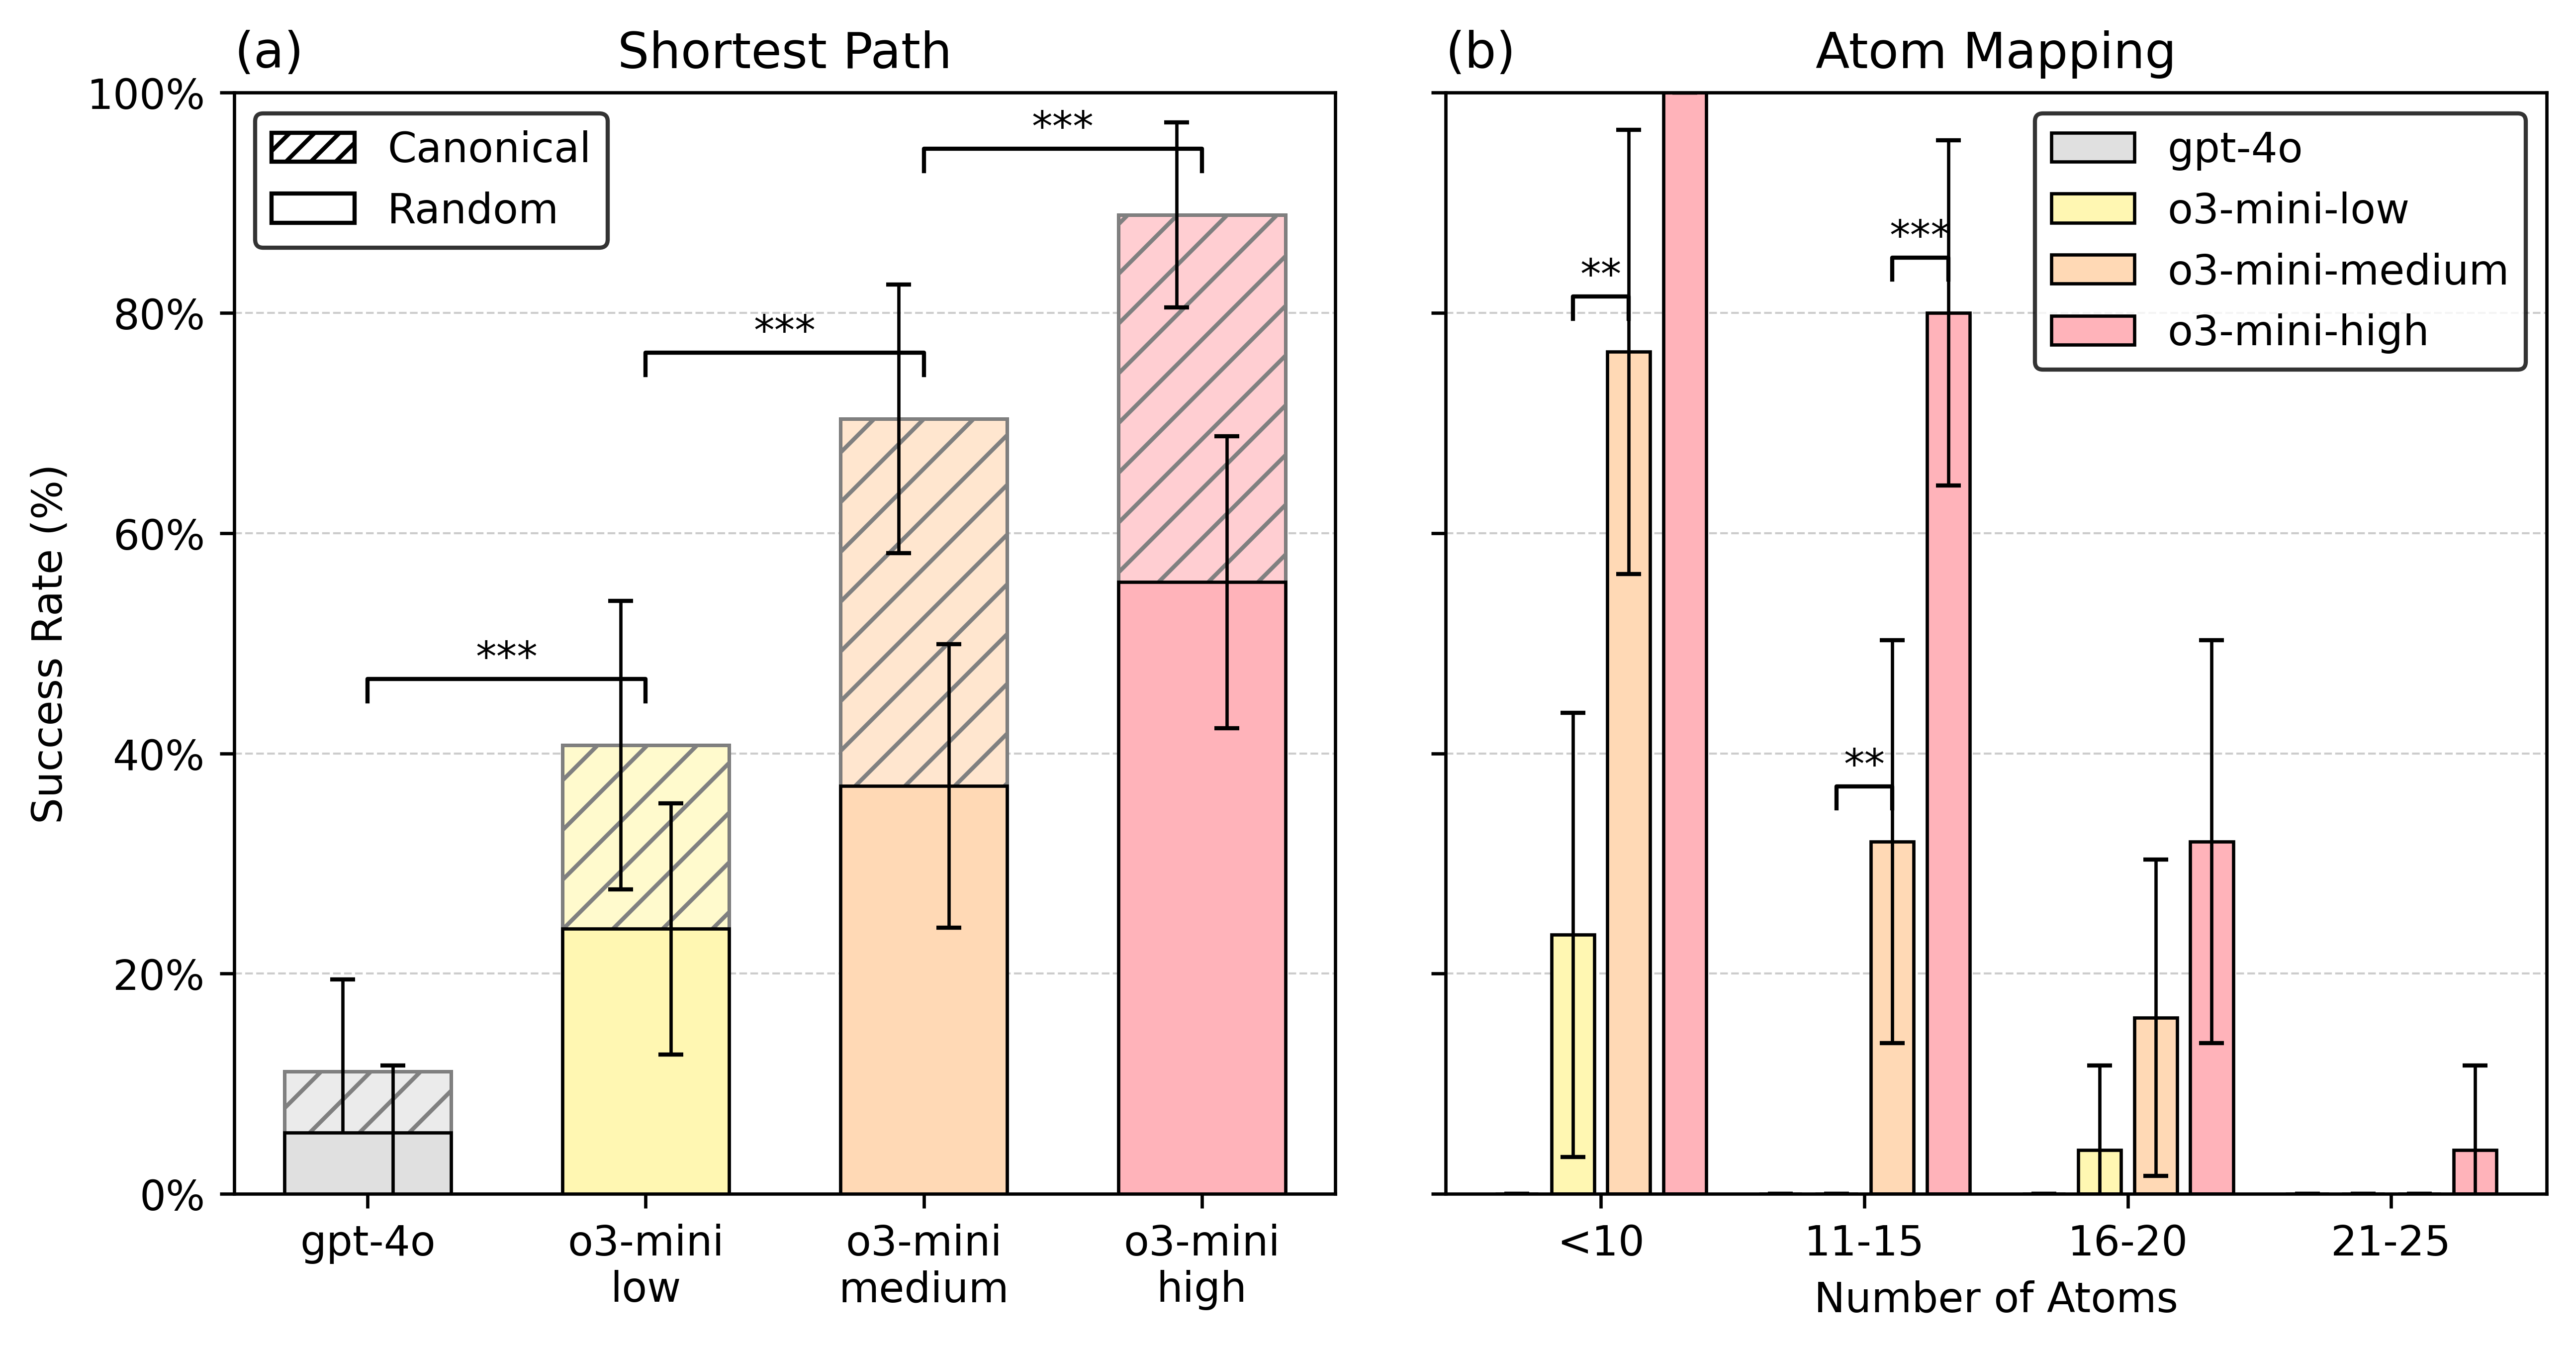

In [7]:
#!/usr/bin/env python3
"""
Figure A-B · Shortest-path & Atom-mapping   (v2, July 2025)

• Handles the new dataframe schema:
    - success   →  is_correct
    - model     →  e.g. 'o3-mini-2025-01-31'
    - thinking_budget  holds 'low'/'medium'/'high'
• Builds a helper column 'plot_model' so the rest of the code can keep using
  the familiar labels:  gpt-4o, o3-mini-low, o3-mini-medium, o3-mini-high, …
"""

# ───────────────────────  Imports & shared helpers  ──────────────────────────
import ast, numpy as np, pandas as pd, matplotlib.pyplot as plt
import matplotlib.ticker as mtick, matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from  scipy.stats import binomtest

# ----------  1.  Palette & colour helpers (unchanged)  ----------------------
pastel = {"violet":"#E2C6FF","indigo":"#C5C6FA","blue":"#BAE1FF",
          "green":"#BFFCC6","yellow":"#FFF7B2","orange":"#FFD9B5",
          "red":"#FFB3BA"}

def lighten(col, f=.35):
    rgb=np.array(mcolors.to_rgb(col)); return tuple(rgb+(1-rgb)*f)

def darken( col, f=.70):
    rgb=np.array(mcolors.to_rgb(col)); return tuple(np.clip(rgb*f,0,1))

model_colors = {
    "gpt-4o":           "#e0e0e0",
    "o3-mini-low":      pastel["yellow"],
    "o3-mini-medium":   pastel["orange"],
    "o3-mini-high":     pastel["red"],
    "gemini-pro-2-5":   pastel["red"],
    "gemini-flash-2-5": pastel["orange"],
    "DeepSeek-V3-0324": "#e0e0e0",
    "DeepSeek-R1-0528": pastel["red"],
}

# ----------  2.  Re-shape the dataframe just once up-front  -----------------
df = df.copy()                                            # don’t mutate upstream
# new helper column with the human-readable labels used everywhere else
df["plot_model"] = df["model"].replace({
    "gpt-4o-2024-11-20": "gpt-4o"        # shrink the long tag
})
mask = df["model"] == "o3-mini-2025-01-31"
df.loc[mask, "plot_model"] = "o3-mini-" + df.loc[mask, "thinking_budget"]

# keep the familiar ordered lists
reasoning_models = ["o3-mini-low", "o3-mini-medium", "o3-mini-high"]
models           = ["gpt-4o"] + reasoning_models

# ----------  3.  Data wrangling (column names updated)  ---------------------
atom_mapping_df = df[df["question_category"] == "atom_mapping"].copy()
atom_mapping_df["n_atoms"] = atom_mapping_df["expected_answer"].apply(
    lambda x: len(x) if isinstance(x, (list, tuple)) else len(ast.literal_eval(x))
)

def to_bucket(n):
    if n<=10: return "<10"
    if n<=15: return "11-15"
    if n<=20: return "16-20"
    if n<=25: return "21-25"
    return None
atom_mapping_df["bar_name"] = atom_mapping_df["n_atoms"].apply(to_bucket)
atom_mapping_df = atom_mapping_df[atom_mapping_df["bar_name"].notnull()]

# ----------  4.  Figure style parameters  -----------------------------------
plt.rcParams.update({
    "font.size":8, "axes.titlesize":12, "axes.labelsize":8,
    "xtick.labelsize":8, "ytick.labelsize":8,
})

fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=600,
                        sharey=True, gridspec_kw={"wspace":0.1})

# ───────────────────────────  (A) Shortest-Path  ────────────────────────────
left_ax = axs[0]
sp_sub = df[df["question_category"]=="shortest_path"]
sp_can = sp_sub[sp_sub["sub_category"]=="canonical"]
sp_rnd = sp_sub[sp_sub["sub_category"]=="random"]

perf_can = sp_can.groupby("plot_model")["is_correct"].mean().reindex(models)
perf_rnd = sp_rnd.groupby("plot_model")["is_correct"].mean().reindex(models)

n_can    = sp_can.groupby("plot_model")["is_correct"].count().reindex(models)
n_rnd    = sp_rnd.groupby("plot_model")["is_correct"].count().reindex(models)

se_can   = np.sqrt(perf_can*(1-perf_can)/n_can)
se_rnd   = np.sqrt(perf_rnd*(1-perf_rnd)/n_rnd)

x, width, offset = np.arange(len(models)), .6, .6*.15
for y in np.arange(.2,1.01,.2):
    left_ax.axhline(y, ls="--", lw=.5, c="grey", alpha=.4, zorder=0)

bars_can = left_ax.bar(
    x, perf_can.values, width=width,
    color=[lighten(model_colors[m]) for m in models],
    edgecolor="black", linewidth=.8, zorder=2
)
for r in bars_can:
    left_ax.add_patch(mpatches.Rectangle(
        (r.get_x(),r.get_y()), r.get_width(), r.get_height(),
        fill=False, hatch="//", ec="grey", lw=.8, zorder=3))

left_ax.errorbar(x-offset, perf_can.values, yerr=1.96*se_can.values,
                 fmt="none", ecolor="black", capsize=3, lw=.8, zorder=4)

bars_rnd = left_ax.bar(
    x, perf_rnd.values, width=width,
    color=[model_colors[m] for m in models],
    edgecolor="black", linewidth=.8, zorder=5
)
left_ax.errorbar(x+offset, perf_rnd.values, yerr=1.96*se_rnd.values,
                 fmt="none", ecolor="black", capsize=3, lw=.8, zorder=6)

# significance
tmp_sp = pd.concat([sp_can, sp_rnd])
for i in range(len(models)-1):
    m1, m2 = models[i], models[i+1]
    d1 = tmp_sp[tmp_sp["plot_model"]==m1][["uuid","is_correct"]].rename(columns={"is_correct":"s1"})
    d2 = tmp_sp[tmp_sp["plot_model"]==m2][["uuid","is_correct"]].rename(columns={"is_correct":"s2"})
    mrg = d1.merge(d2, on="uuid")
    b = ((mrg.s1==1)&(mrg.s2==0)).sum(); c = ((mrg.s1==0)&(mrg.s2==1)).sum()
    if b+c:
        p = binomtest(b, n=b+c, p=.5, alternative="less").pvalue
        if p<.05:
            stars="***" if p<.001 else "**" if p<.01 else "*"
            base=max(perf_can[i], perf_rnd[i], perf_can[i+1], perf_rnd[i+1])
            y = base+.04
            left_ax.plot([x[i], x[i], x[i+1], x[i+1]], [y, y+.02, y+.02, y],
                         c="black", lw=1, zorder=7)
            left_ax.text((x[i]+x[i+1])/2, y+.02, stars,
                         ha="center", va="bottom", fontsize=10, zorder=8)

left_ax.set_title("Shortest Path", loc="center", fontsize=12)
left_ax.set_xticks(x)
left_ax.set_xticklabels(["gpt-4o", "o3-mini\nlow", "o3-mini\nmedium", "o3-mini\nhigh"],
                        rotation=0, ha="center", fontsize=10)
left_ax.set_ylim(0,1)
left_ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
left_ax.set_ylabel("Success Rate (%)", fontsize=10)
left_ax.set_box_aspect(1)
left_ax.legend(handles=[
        mpatches.Patch(fc="white", ec="black", hatch="////", label="Canonical"),
        mpatches.Patch(fc="white", ec="black", label="Random")],
    fontsize=10, frameon=True, edgecolor="black",
    loc="upper left")


left_ax.set_yticklabels(ax.get_yticks(), fontsize=10)

# ───────────────────────────  (B) Atom-Mapping  ─────────────────────────────
right_ax    = axs[1]
group_order = ["<10","11-15","16-20","21-25"]
gx          = np.arange(len(group_order))
gw, gap     = .8, .05
bar_w       = (gw - gap*(len(reasoning_models)))/ (len(reasoning_models)+1)

# mean & CI
perf_df = (atom_mapping_df[atom_mapping_df["sub_category"]=="random"]
           .groupby(["bar_name","plot_model"])["is_correct"]
           .mean().unstack())

cnt_df  = (atom_mapping_df[atom_mapping_df["sub_category"]=="random"]
           .groupby(["bar_name","plot_model"])["is_correct"]
           .count().unstack())

err_df  = np.sqrt(perf_df*(1-perf_df)/cnt_df)*1.96

for y in np.arange(.2,1.01,.2):
    right_ax.axhline(y, ls="--", lw=.5, c="grey", alpha=.4, zorder=0)

for i, m in enumerate(["gpt-4o"]+reasoning_models):
    pos  = gx - gw/2 + i*(bar_w+gap) + bar_w/2
    vals = [perf_df.loc[g, m] for g in group_order]
    errs = [err_df.loc[g, m] for g in group_order]
    right_ax.bar(pos, vals, width=bar_w,
                 color=model_colors.get(m, pastel["blue"]),
                 edgecolor="black", lw=.8, label=m, zorder=2)
    right_ax.errorbar(pos, vals, yerr=errs, fmt="none",
                      capsize=3, ecolor="black", lw=.8, zorder=3)

# significance within each bucket
for gi, grp in enumerate(group_order):
    sub = atom_mapping_df[(atom_mapping_df["bar_name"]==grp)&
                          (atom_mapping_df["sub_category"]=="random")]
    for i in range(len(models)-1):
        m1, m2 = models[i], models[i+1]
        d1 = sub[sub["plot_model"]==m1][["uuid","is_correct"]].rename(columns={"is_correct":"s1"})
        d2 = sub[sub["plot_model"]==m2][["uuid","is_correct"]].rename(columns={"is_correct":"s2"})
        mrg = d1.merge(d2, on="uuid")
        b = ((mrg.s1==1)&(mrg.s2==0)).sum(); c = ((mrg.s1==0)&(mrg.s2==1)).sum()
        if b+c:
            p = binomtest(b, n=b+c, p=.5, alternative="less").pvalue
            if p<.05:
                stars = "***" if p<.001 else "**" if p<.01 else "*"
                base = max(perf_df.loc[grp, m1], perf_df.loc[grp, m2])
                x1 = gx[gi] - gw/2 + i*(bar_w+gap) + bar_w/2
                x2 = gx[gi] - gw/2 + (i+1)*(bar_w+gap) + bar_w/2
                y  = base + .03
                right_ax.plot([x1, x1, x2, x2], [y, y+.02, y+.02, y],
                              c="black", lw=1, zorder=4)
                right_ax.text((x1+x2)/2, y+.02, stars,
                              ha="center", va="bottom", fontsize=10, zorder=5)

right_ax.set_title("Atom Mapping", loc="center", fontsize=12)
right_ax.set_xlabel("Number of Atoms", fontsize=10)
right_ax.set_xticks(gx)
right_ax.set_xticklabels(group_order, fontsize=10)
right_ax.set_ylim(0,1)
right_ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
right_ax.set_box_aspect(1)
right_ax.legend(fontsize=10, frameon=True, edgecolor="black")


# Add subplot labels a–g outside the plots
labels = ['a', 'b']
axes  = [left_ax, right_ax]

for ax, label in zip(axes, labels):
    fig.text(ax.get_position().x0 - 0.0,
             ax.get_position().y1 + 0.01,
             f"({label})",
             fontsize=12, ha="left", va="bottom")

# ───────────────────────────  Save & show  ─────────────────────────────────--
plt.tight_layout()
#plt.savefig("figures/fig_shortestpath_atommapping_updated.png", bbox_inches="tight")
plt.show()

# IUPAC naming error analysis

In [8]:
import json
import pandas as pd
from tqdm import tqdm
from rdkit import RDLogger

from utils.answer_verifier import AnswerVerifier
from utils import parser

RDLogger.DisableLog('rdApp.*')
tqdm.pandas()

# Load model responses
#df = pd.read_csv('model_responses/model_responses.csv')
#df.groupby(['model', 'thinking_budget']).size().reset_index(name='count')
df_iupac = pd.read_csv('model_responses/model_responses_additional.csv')



#additional_smiles_to_iupac_questions = read_jsonl("questions/additional_smiles_to_iupac.jsonl")
#additional_question_dict = {q["uuid"]: q for q in additional_smiles_to_iupac_questions}
#additional_uuids = set(additional_question_dict.keys())


# Parse responses
parser = parser.AnswerParser("questions/additional_smiles_to_iupac.jsonl")
df_iupac["parsed_answer"] = df_iupac.apply(lambda row: parser.parse(row["uuid"], row["raw_model_answer"]), axis=1)

# Check answers
answer_checker = AnswerVerifier("questions/additional_smiles_to_iupac.jsonl")
df_iupac[['is_correct','opsin_smiles']] = (df_iupac.progress_apply(lambda row: pd.Series(answer_checker.check_answer(row["uuid"], row["parsed_answer"])),axis=1))

# Load question data
all_questions = []
with open("questions/additional_smiles_to_iupac.jsonl", 'r') as f:
    for line in f:
        all_questions.append(json.loads(line))
question_dict = {q["uuid"]: q for q in all_questions}

# Add useful question columns to dataframe
df_iupac["question_category"] = df_iupac["uuid"].apply(lambda x: question_dict[x]["question_category"])
df_iupac["sub_category"] = df_iupac["uuid"].apply(lambda x: question_dict[x]["sub_category"])
df_iupac["expected_answer"] = df_iupac["uuid"].apply(lambda x: question_dict[x]["answer"])

# Making this column integers when possible helps with plotting later
df_iupac['thinking_budget'] = df_iupac['thinking_budget'].apply(lambda x: int(x) if isinstance(x, str) and x.isdigit() else x)

# Calculating output tokens
df_iupac["output_tokens"] = df_iupac["total_tokens"] - df_iupac["prompt_tokens"]

100%|████████████████████████████████████████████████████████████████████| 1040/1040 [00:00<00:00, 2785.98it/s]


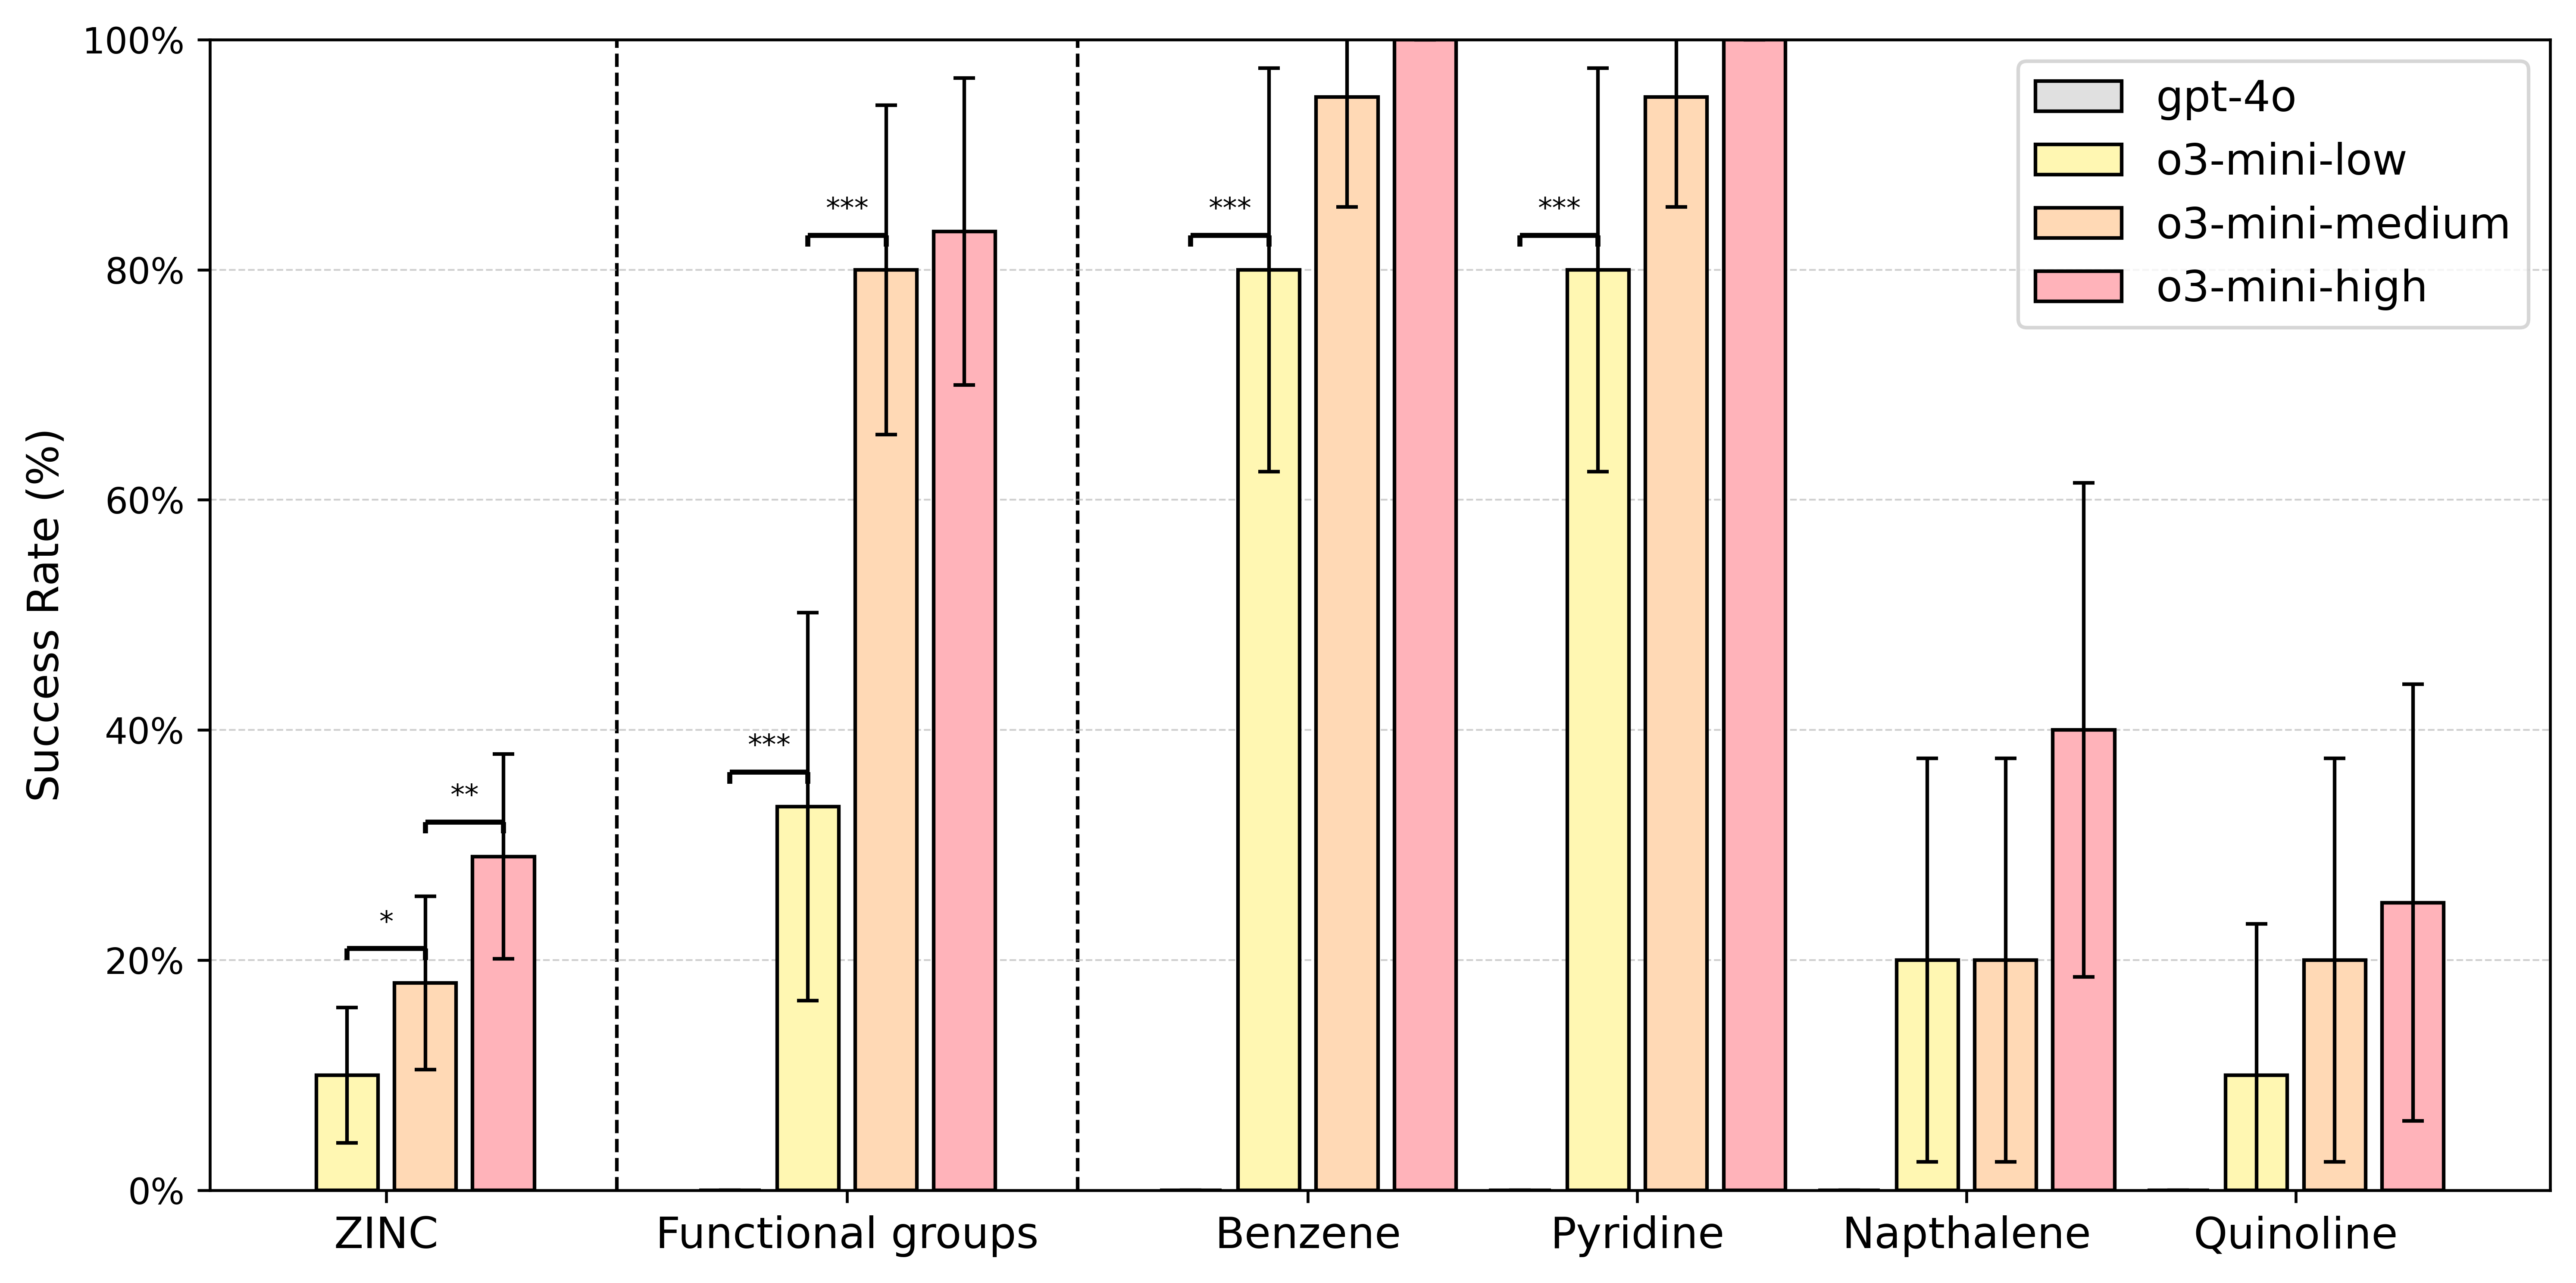

In [9]:
#!/usr/bin/env python3
"""
Re-plot the SMILES → IUPAC sub-category breakdown (case-robust)
==============================================================
* **Assumes** a pandas **DataFrame `df` already in memory** with columns
  `uuid`, `model`, `thinking_budget`, `sub_category`, **`is_correct`** (boolean 0/1).
* Builds a helper column **`plot_model`** so we can keep referring to
  the familiar labels `gpt-4o`, `o3-mini-low`, `o3-mini-medium`, `o3-mini-high`.
* **NEW:** handles lower/upper-case mismatches in `sub_category` by
  comparing everything in lower-case –  fixes the “only ZINC plotted” issue.
* **Read-only** – nothing is written back to the original `df`.
"""

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import binomtest
import pandas as pd

# ───────────────────────────────────────────────────────────
#  0.  Global font settings (all text 8 pt, titles 10 pt)
# ───────────────────────────────────────────────────────────
plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 10,
    "axes.labelsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
})

# ───────────────────────────────────────────────────────────
#  1.  Make a clean working copy & derive helper columns
# ───────────────────────────────────────────────────────────
df_zinc = df[
    (df["sub_category"] == "zinc_canonical") &
    (df["model"] == "o3-mini-2025-01-31")
].copy()

df_plot = pd.concat([df_iupac, df_zinc], ignore_index=True)

# Human-readable model labels used for plotting
_df_pm = df_plot["model"].copy()

df_plot["plot_model"] = _df_pm.replace({
    "gpt-4o-2024-11-20": "gpt-4o",
})
mask_o3 = df_plot["model"] == "o3-mini-2025-01-31"
df_plot.loc[mask_o3, "plot_model"] = "o3-mini-" + df_plot.loc[mask_o3, "thinking_budget"].astype(str)

# Lower-case helper for case-insensitive sub-category matching
df_plot["sub_category_lower"] = df_plot["sub_category"].str.lower()

# ───────────────────────────────────────────────────────────
#  2.  Configuration – plot order & colours
# ───────────────────────────────────────────────────────────
models = ["gpt-4o", "o3-mini-low", "o3-mini-medium", "o3-mini-high"]

pastel = {
    "violet":   "#E2C6FF",
    "indigo":   "#C5C6FA",
    "blue":     "#BAE1FF",
    "green":    "#BFFCC6",
    "yellow":   "#FFF7B2",
    "orange":   "#FFD9B5",
    "red":      "#FFB3BA",
}

model_colors = {
    "gpt-4o":           "#e0e0e0",
    "o3-mini-low":      pastel["yellow"],
    "o3-mini-medium":   pastel["orange"],
    "o3-mini-high":     pastel["red"],
}

sub_categories_to_plot = [
    "zinc_canonical",
    "FG_canonical",
    "Benzene_canonical",
    "Pyridine_canonical",
    "Napthalene_canonical",
    "Quinoline_canonical",
]

# Logical sections (for dashed separators)
sections = [
    ["zinc_canonical"],
    ["FG_canonical"],
    [
        "Benzene_canonical",
        "Pyridine_canonical",
        "Napthalene_canonical",
        "Quinoline_canonical",
    ],
]

# ───────────────────────────────────────────────────────────
#  3.  Compute bar positions
# ───────────────────────────────────────────────────────────
extra_gap = 0.4
positions: dict[str, float] = {}
cur = 0.0
for idx, sec in enumerate(sections):
    for sub in sec:
        positions[sub] = cur
        cur += 1.0
    if idx < len(sections) - 1:
        cur += extra_gap

group_positions = [positions[s] for s in sub_categories_to_plot]

group_width = 0.9
bar_gap = 0.05
n_models = len(models)
bar_width = (group_width - (n_models - 1) * bar_gap) / n_models

# ───────────────────────────────────────────────────────────
#  4.  Plot
# ───────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 5), dpi=600)
bar_pos: dict[tuple[str, str], float] = {}

for j, model in enumerate(models):
    means, cis, xs = [], [], []

    for sub_cat in sub_categories_to_plot:
        base_x = positions[sub_cat]
        x = base_x - group_width / 2 + j * (bar_width + bar_gap) + bar_width / 2
        xs.append(x)
        bar_pos[(sub_cat, model)] = x

        sub_cat_lower = sub_cat.lower()
        mask = (
            (df_plot["sub_category_lower"].to_numpy() == sub_cat_lower) &
            (df_plot["plot_model"].to_numpy() == model)
        )
        slice_df = df_plot.loc[mask]

        if slice_df.empty:
            means.append(np.nan)
            cis.append(0.0)
            continue

        mean = slice_df["is_correct"].mean()
        n = len(slice_df)
        ci = 1.96 * np.sqrt(mean * (1 - mean) / n)
        means.append(mean)
        cis.append(ci)

    ax.bar(
        xs,
        means,
        width=bar_width,
        color=model_colors[model],
        edgecolor="black",
        yerr=cis,
        error_kw={"elinewidth": 1, "ecolor": "black", "capsize": 3},
        label=model,
        zorder=3,
    )

# ───────────────────────────────────────────────────────────
#  5.  Cosmetic grid & separators
# ───────────────────────────────────────────────────────────
for idx in range(len(sections) - 1):
    last_cat = sections[idx][-1]
    next_cat = sections[idx + 1][0]
    xb = (positions[last_cat] + positions[next_cat]) / 2.0
    ax.axvline(x=xb, linestyle="--", color="black", linewidth=1, zorder=1)

pretty_labels = [
    "ZINC",
    "Functional groups",
    "Benzene",
    "Pyridine",
    "Napthalene",
    "Quinoline",
]
ax.set_xticks(group_positions)
ax.set_xticklabels(pretty_labels, rotation=0, ha="center", fontsize=12)

ax.set_ylabel("Success Rate (%)", fontsize=12)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_ylim(0, 1)
ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6, zorder=0)
# Uncomment the following line to include a title (10 pt)
# ax.set_title("SMILES → IUPAC: sub-category breakdown", fontsize=10)
ax.legend(fontsize=12)
ax.tick_params(axis='y', labelsize=10)

# ───────────────────────────────────────────────────────────
#  6.  One-sided McNemar significance  ▸ helper with “staples”
# ───────────────────────────────────────────────────────────

def _annotate_hbar(
    ax,
    x1: float,
    x2: float,
    y_base: float,
    stars: str,
    pad: float = 0.03,      # space above the taller bar
    tick: float = 0.01,     # length of the little vertical ticks
    text_gap: float = 0.01, # gap above the staple for the stars text
    lw: float = 1.4,
    fs: int = 8,
):
    """Draw a ‘staple’ significance bracket."""
    y = y_base + pad           # height of the horizontal segment

    # horizontal segment
    ax.hlines(y, x1, x2, lw=lw, color="black", zorder=4)
    # vertical ticks at both ends
    ax.vlines([x1, x2], y - tick, y, lw=lw, color="black", zorder=4)
    # text centred above the staple
    ax.text((x1 + x2) / 2, y + text_gap, stars,
            ha="center", va="bottom", fontsize=fs, zorder=4)


# ───────────────────────────────────────────────────────────
#  6b.  Compute & annotate significance
# ───────────────────────────────────────────────────────────
for sub_cat in sub_categories_to_plot:
    sub_cat_lower = sub_cat.lower()
    for i in range(len(models) - 1):
        m1, m2 = models[i], models[i + 1]
        x1, x2 = bar_pos[(sub_cat, m1)], bar_pos[(sub_cat, m2)]

        mask1 = (
            (df_plot["sub_category_lower"].to_numpy() == sub_cat_lower) &
            (df_plot["plot_model"].to_numpy() == m1)
        )
        mask2 = (
            (df_plot["sub_category_lower"].to_numpy() == sub_cat_lower) &
            (df_plot["plot_model"].to_numpy() == m2)
        )
        df1, df2 = df_plot.loc[mask1], df_plot.loc[mask2]
        if df1.empty or df2.empty:
            continue

        merged = (
            df1[["uuid", "is_correct"]].rename(columns={"is_correct": "a"})
            .merge(df2[["uuid", "is_correct"]].rename(columns={"is_correct": "b"}), on="uuid")
        )
        b = ((merged["a"] == 1) & (merged["b"] == 0)).sum()
        c = ((merged["a"] == 0) & (merged["b"] == 1)).sum()
        n_pairs = b + c
        if not n_pairs:
            continue
        p_val = binomtest(c, n=n_pairs, alternative="greater").pvalue
        if p_val < 0.05:
            stars = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*"
            y_base = max(df1["is_correct"].mean(), df2["is_correct"].mean())
            _annotate_hbar(ax, x1, x2, y_base, stars)

# ───────────────────────────────────────────────────────────
#  7.  Save & show
# ───────────────────────────────────────────────────────────
plt.tight_layout()
plt.savefig("figures/smiles_to_iupac_all_updated.pdf", bbox_inches="tight")
plt.show()


# NMR elucidation questions correct by Gemini pro

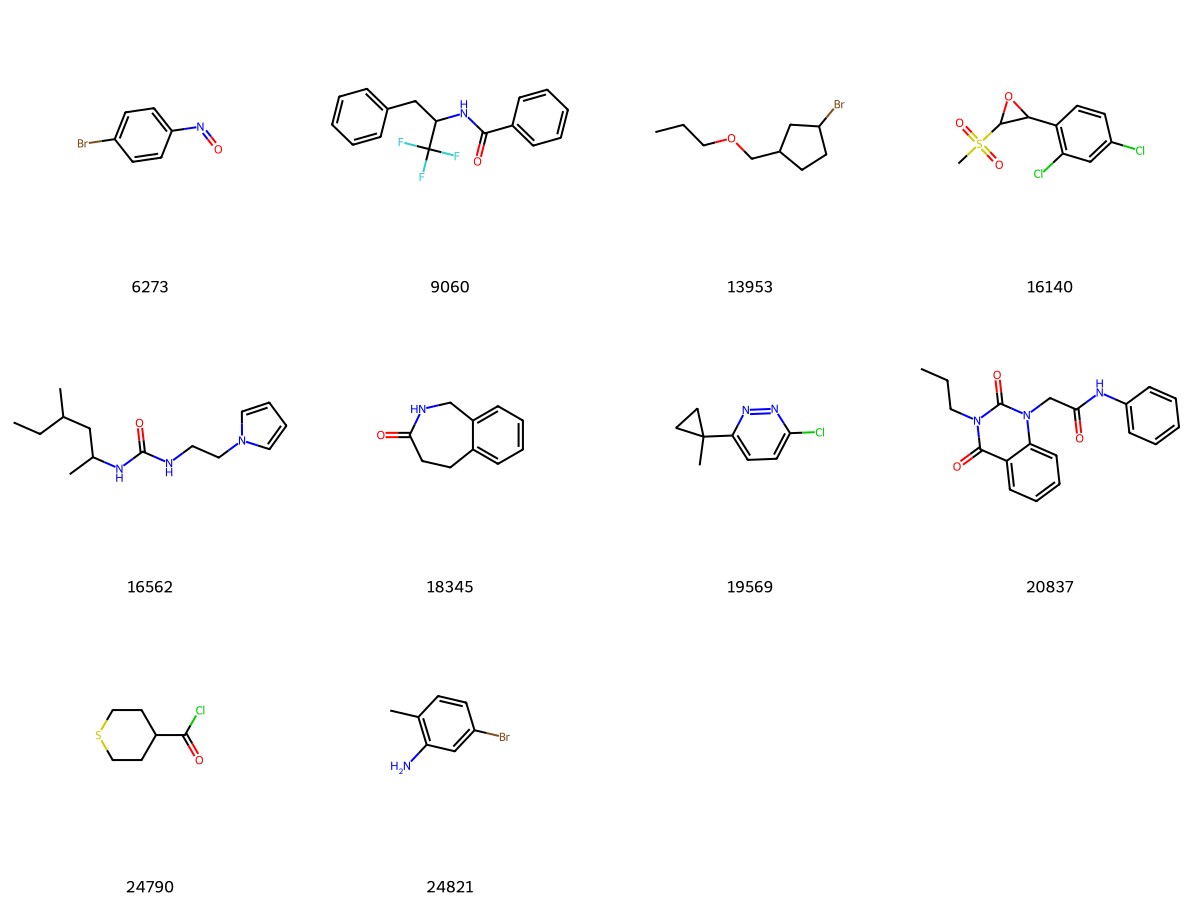

In [10]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import matplotlib.pyplot as plt

# Filter the subset
subset = df[
    (df["sub_category"] == "zinc_2d") &
    (df["is_correct"]) &
    (df["model"] == "gemini-pro-2-5") &
    (df["thinking_budget"] == 32768)
]

# Sort by reasoning tokens
subset = subset.sort_values(by="reasoning_tokens")

# Convert SMILES to RDKit molecule objects
smiles_list = subset["parsed_answer"].tolist()
mols = [Chem.MolFromSmiles(smile) for smile in smiles_list if Chem.MolFromSmiles(smile) is not None]

# Create legends from sorted reasoning tokens
legends = [str(round(x)) for x in subset["reasoning_tokens"]]

# Set grid options
n_cols = 4
img = Draw.MolsToGridImage(
    mols,
    molsPerRow=n_cols,
    subImgSize=(300, 300),
    useSVG=False,
    returnPNG=False,
    legends=legends,
)


# now img is a PIL.Image, so save it directly:
img.save('figures/gemini_pro_2d_nmr_correct.png', dpi=(600, 600))
img

# Gemini Pro reasoning excerpt

============================== PROMPT ==============================
Write the SMILES string of the molecule consistent with this data.

Formula: C19H19N3O3

1H NMR: δ 7.63 (ddd, J = 7.88, 1.41, 0.51 Hz, 1H), 7.6 (ddd, J = 8.14, 7.52, 1.41 Hz, 1H), 7.48 (dddd, J = 8.16, 1.47, 1.24, 0.54 Hz, 2H), 7.39 (ddd, J = 8.14, 1.39, 0.51 Hz, 1H), 7.34 (ddd, J = 7.88, 7.52, 1.39 Hz, 1H), 7.27 (dddd, J = 8.16, 7.76, 1.43, 0.54 Hz, 2H), 7.07 (tt, J = 7.76, 1.24 Hz, 1H), 4.66 (s, 2H), 3.85 (t, J = 6.97 Hz, 2H), 1.71 (tq, J = 6.97, 6.61 Hz, 2H), 0.96 (t, J = 6.61 Hz, 3H).

13C NMR: δ 169.1 (1C, s), 161.4 (1C, s), 152.5 (1C, s), 140.5 (1C, s), 138.07 (1C, s), 135.15 (1C, s), 129 (1C, s), 128.9 (2C, s), 126.75 (1C, s), 123.58 (1C, s), 120.2 (2C, s), 115.6 (1C, s), 115.2 (1C, s), 47.35 (1C, s), 42.6 (1C, s), 21 (1C, s), 11.15 (1C, s).

COSY (δH, δH): (7.6, 7.39), (7.6, 7.34), (7.63, 7.34), (7.07, 7.27), (7.48, 7.27), (3.85, 1.71), (1.71, 0.96).

HSQC (δH, δC): (7.6, 135.15), (7.63, 129), (7.27, 128.9), (

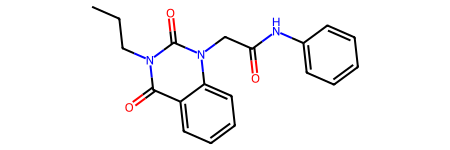

In [11]:
idx = 7

all_questions = []
with open("questions/chemiq.jsonl", 'r') as f:
    for line in f:
        all_questions.append(json.loads(line))
question_dict = {q["uuid"]: q for q in all_questions}

q = question_dict['1b8804c1-d279-422a-ad63-755bb021b922']

print("="*30 + " PROMPT " + "="*30)
print(q["prompt"])
print("="*30 + " REASONING " + "="*30)
print(subset.iloc[idx]["reasoning_trace"])
print("="*30 + " ANSWER " + "="*30)
print(subset.iloc[idx]["parsed_answer"])
smi = subset.iloc[idx]["parsed_answer"]
display(Chem.MolFromSmiles(smi))

# Gemini Flash

/tmp/ipykernel_1534665/3499627464.py:354: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


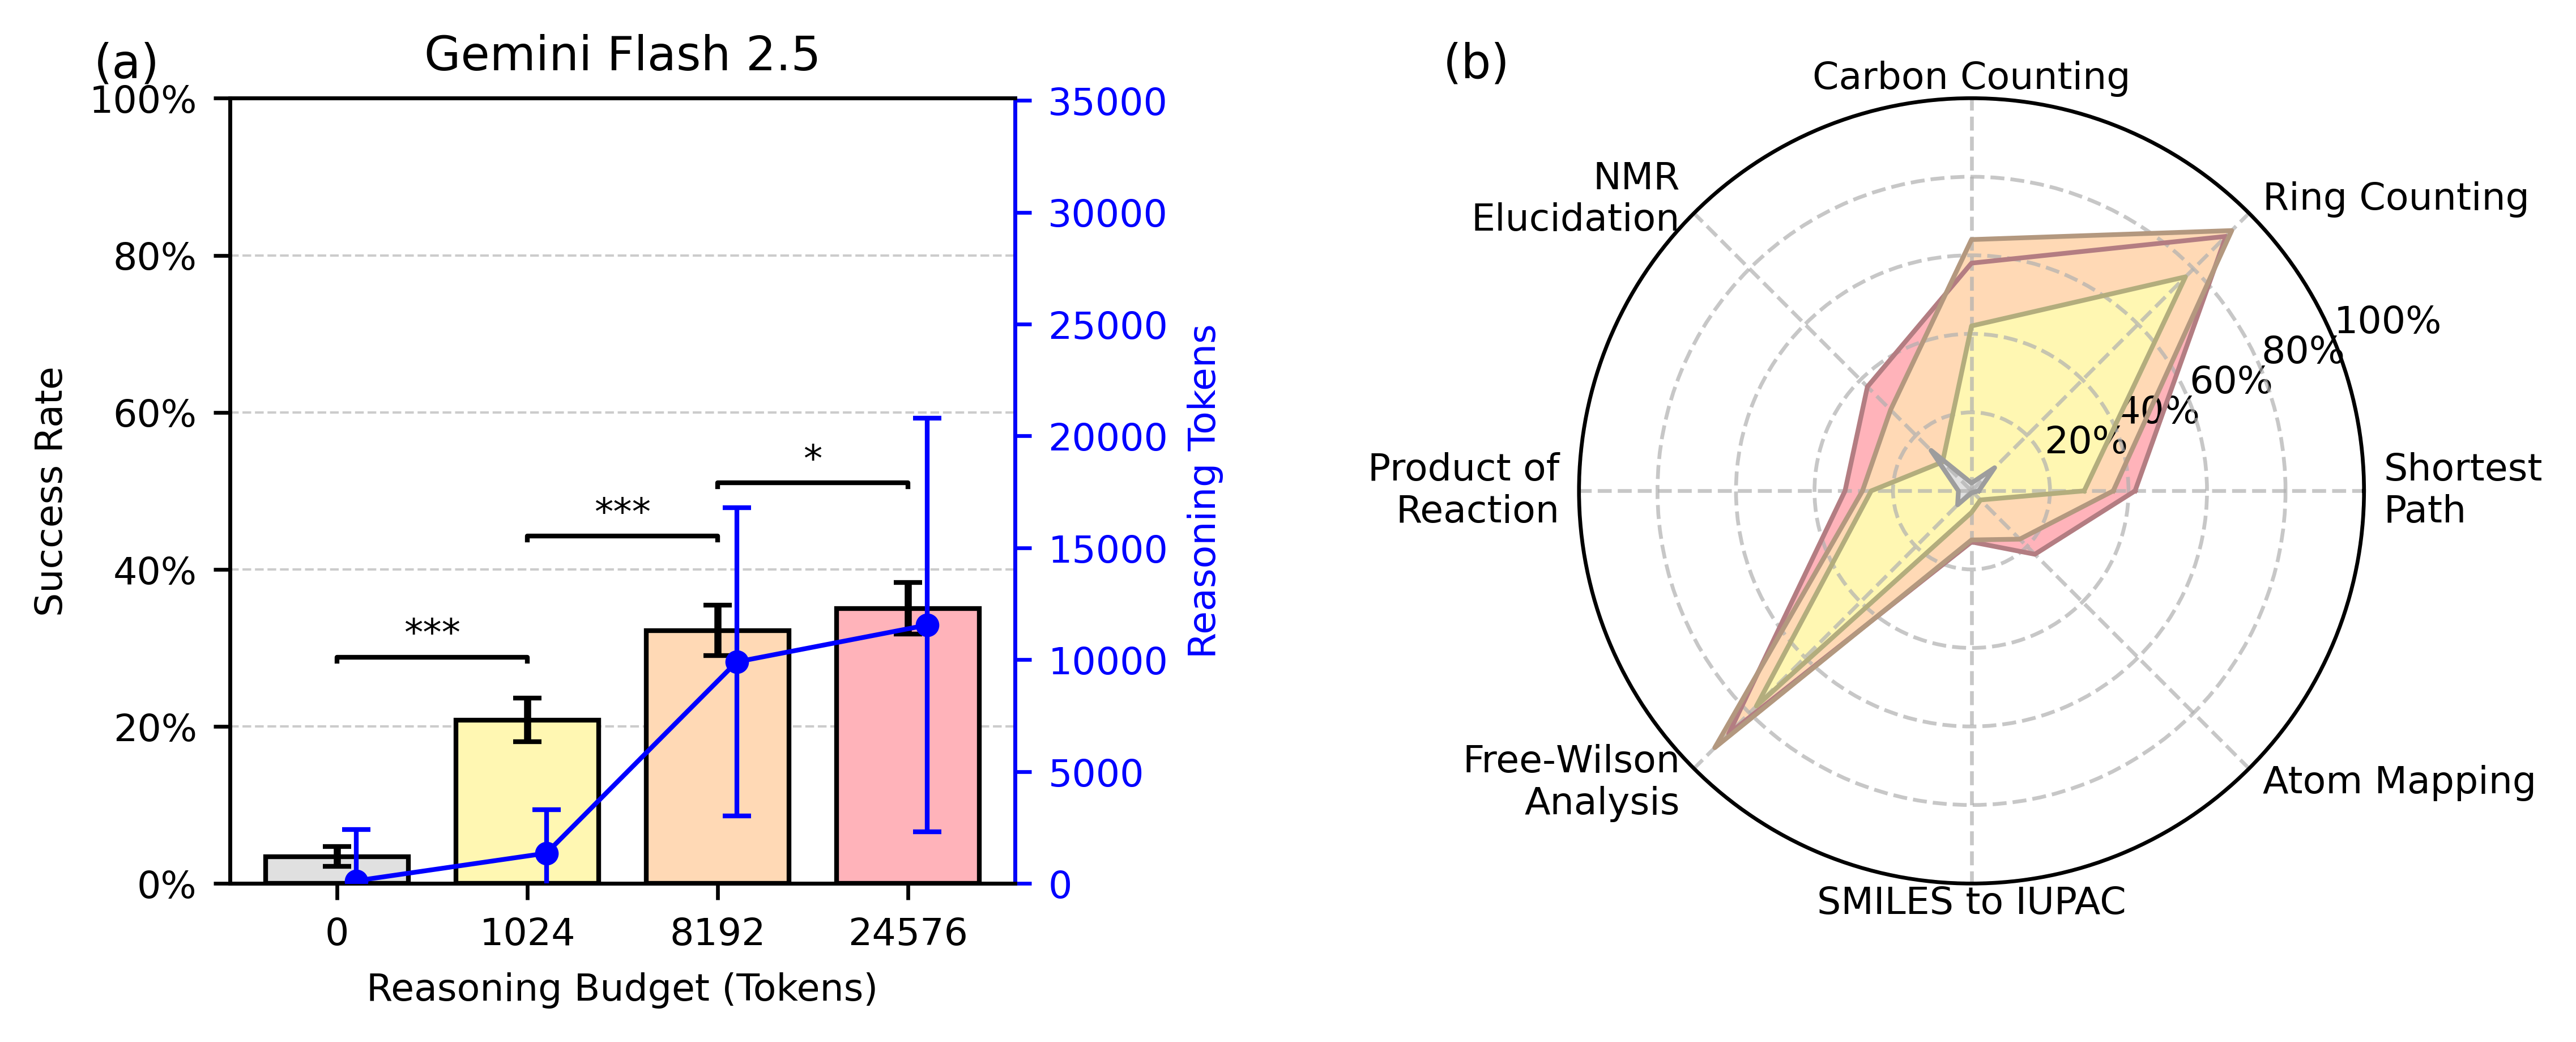

In [12]:
#!/usr/bin/env python3
"""
Generate a combined bar/token plot and radar chart for **Gemini Flash 2.5** only.

Assumes a pandas DataFrame named **df** already exists in memory with at least
these columns:
    - uuid                : unique identifier of each question instance
    - model               : model name (string), here we filter == "gemini-flash-2-5"
    - thinking_budget     : integer reasoning‑token budget used for this run
    - question_category   : the chemistry question type (see *question_order*)
    - sub_category        : sub‑class for certain questions (SMILES‑to‑IUPAC)
    - is_correct          : 1 if answer correct, else 0
    - reasoning_tokens    : number of tokens actually generated in the chain‑of‑thought

The script recreates the colour scheme and helper utilities from the original
multi‑model figure, but focuses solely on Gemini Flash 2.5. You will obtain a
single‑row figure with the bar/token plot on the left and the matching radar on
the right, saved as **figures/gemini_flash_2_5_radar_bar.pdf**.
"""
from __future__ import annotations
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from scipy.stats import binomtest
try:
    from statsmodels.stats.contingency import mcnemar as sm_mcnemar
except ImportError:
    sm_mcnemar = None

# ───────────────────────────────────────────────────────────
#  Statistical helpers (unchanged)
# ───────────────────────────────────────────────────────────

def mcnemar_one_sided(b: int, c: int) -> float:
    """One‑sided McNemar exact test (H0: b ≥ c)."""
    n = b + c
    if n == 0:
        return 1.0
    if sm_mcnemar is not None:
        p_two = sm_mcnemar([[0, b], [c, 0]], exact=True).pvalue
        return p_two / 2 if c > b else 1.0
    return binomtest(c, n=n, alternative="greater").pvalue

def p_to_stars(p: float) -> str:
    return "***" if p < .001 else "**" if p < .01 else "*" if p < .05 else "n.s."


def mcnemar_adjacent_pvals(df: pd.DataFrame, category_col: str, ordered: list) -> list[float]:
    """Compute one‑sided McNemar p‑values for adjacent pairs along *ordered*."""
    pvals: list[float] = []
    for l, r in zip(ordered[:-1], ordered[1:]):
        pv = (
            df[df[category_col].isin([l, r])]
            .pivot(index="uuid", columns=category_col, values="is_correct")
            .dropna()
        )
        if pv.empty:
            pvals.append(1.0)
            continue
        b = ((pv[l] == 1) & (pv[r] == 0)).sum()
        c = ((pv[l] == 0) & (pv[r] == 1)).sum()
        pvals.append(mcnemar_one_sided(b, c))
    return pvals


def add_significance_brackets(
    ax, bar_x, perf, pvals, bar_w: float = 0.75, base_offset: float = 0.08, step: float = 0.04
):
    """Annotate adjacent bars with significance brackets."""
    for i, p in enumerate(pvals):
        x1, x2 = bar_x[i], bar_x[i + 1]
        y = max(perf[i], perf[i + 1]) + base_offset + i * step
        ax.plot([x1, x1, x2, x2], [y - 0.005, y, y, y - 0.005], color="black", lw=1, zorder=6)
        ax.text((x1 + x2) / 2, y + 0.005, p_to_stars(p), ha="center", va="bottom", fontsize=8, zorder=6)


# ───────────────────────────────────────────────────────────
#  Bar / token‑line utilities (unchanged logic)
# ───────────────────────────────────────────────────────────

def calc_numeric(df_subset: pd.DataFrame):
    df = df_subset.copy()
    df["thinking_budget"] = df["thinking_budget"].astype(int)
    budgets = sorted(df["thinking_budget"].unique())
    n = df["uuid"].nunique()

    perf = df.groupby("thinking_budget")["is_correct"].mean().reindex(budgets)
    ci = np.sqrt(perf * (1 - perf) / n) * 1.96

    avg = df.groupby("thinking_budget")["reasoning_tokens"].mean().reindex(budgets)
    std = df.groupby("thinking_budget")["reasoning_tokens"].std().reindex(budgets).fillna(0)
    return budgets, perf.values, ci.values, avg.values, std.values


def _orig_plot_bars(
    ax,
    x,
    perf,
    ci,
    avg,
    std,
    labels,
    colors,
    pvals=None,
    tok_max=None,
    *,
    show_tok_ylabel=False,
    bar_w: float = 0.75,
    offset: float = 0.1,
):
    """Draw the composite bar + token‑line graphic."""
    ax.bar(x, perf, width=bar_w, color=colors, edgecolor="black", zorder=3)
    ax.errorbar(x, perf, yerr=ci, fmt="none", capsize=3, ecolor="black", zorder=4)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=8)
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    ax.tick_params(axis="x", labelsize=8)
    ax.tick_params(axis="y", labelsize=8)

    # background grid
    for y in np.arange(0.2, 1, 0.2):
        ax.axhline(y, ls="--", lw=0.5, color="grey", alpha=0.4, zorder=1)

    ax2 = ax.twinx()
    ax2.errorbar(
        x + offset,
        avg,
        yerr=std,
        marker="o",
        ms=4,
        lw=1,
        capsize=3,
        color="blue",
        zorder=5,
    )
    ax2.set_ylim(0, tok_max)
    ax2.tick_params(axis="y", colors="blue", labelsize=8)
    ax2.spines["right"].set_color("blue")
    if not show_tok_ylabel:
        ax2.set_yticklabels([])
    else:
        ax2.set_ylabel("Reasoning Tokens", color="blue", fontsize=8)

    if pvals is not None:
        add_significance_brackets(ax, x, perf, pvals, bar_w=bar_w)


def plot_bars(ax, *args, **kwargs):
    """Wrapper enforcing square aspect."""
    _orig_plot_bars(ax, *args, **kwargs)
    ax.set_box_aspect(1)


# ───────────────────────────────────────────────────────────
#  Radar‑chart utilities (unchanged logic)
# ───────────────────────────────────────────────────────────
question_order = [
    "shortest_path",
    "counting_ring",
    "counting_carbon",
    "nmr_elucidation",
    "reaction",
    "sar",
    "smiles_to_iupac",
    "atom_mapping",
]
question_labels = {
    "counting_carbon": "Carbon Counting",
    "counting_ring": "Ring Counting",
    "sar": "Free‑Wilson\nAnalysis",
    "shortest_path": "Shortest\nPath",
    "atom_mapping": "Atom Mapping",
    "smiles_to_iupac": "SMILES to IUPAC",
    "reaction": "Product of\nReaction",
    "nmr_elucidation": "NMR\nElucidation",
}


def darken(col: str, f: float = 0.7):
    rgb = np.array(mcolors.to_rgb(col))
    return tuple(np.clip(rgb * f, 0, 1))


def success_rates(base: pd.DataFrame, grp: pd.DataFrame):
    rates: list[float] = []
    for q in question_order:
        if q == "smiles_to_iupac":
            base_mask = (base["question_category"] == q) & (
                base["sub_category"].isin(["zinc_canonical", "zinc_random"])
            )
            grp_mask = (grp["question_category"] == q) & (
                grp["sub_category"].isin(["zinc_canonical", "zinc_random"])
            )
        else:
            base_mask = base["question_category"] == q
            grp_mask = grp["question_category"] == q
        denom = base.loc[base_mask, "uuid"].nunique()
        num = grp.loc[grp_mask, "is_correct"].sum()
        rates.append(num / denom if denom else 0)
    return rates


def beautify_axis(ax, show_xt: bool = False):
    N = len(question_order)
    label_angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    ax.set_xticks(label_angles)
    ax.set_xticklabels([])

    if show_xt:
        offset_r = 1.05
        for txt, ang in zip(question_order, label_angles):
            lbl = question_labels.get(txt, txt)
            deg = np.degrees(ang)
            ha = "right" if 90 < deg < 270 else ("center" if deg in (90, 270) else "left")
            ax.text(ang, offset_r, lbl, ha=ha, va="center", fontsize=8)

    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["20%", "40%", "60%", "80%", "100%"], fontsize=8)

    for gl in ax.get_xgridlines() + ax.get_ygridlines():
        gl.set_linestyle("--")
        gl.set_alpha(0.7)


def plot_radar(ax, subset_df, keys, lookup, colour_for):
    """Draw radar with full tick labels."""
    handles = []
    for key in reversed(keys):
        grp = lookup(key)
        vals = np.asarray(success_rates(subset_df, grp))
        ang = np.linspace(0, 2 * np.pi, len(vals), endpoint=False)

        # close the loop
        vals = np.r_[vals, vals[0]]
        ang = np.r_[ang, ang[0]]

        base = colour_for(key)
        ax.fill(ang, vals, fc=base, ec=None, alpha=1)
        ax.plot(ang, vals, lw=1, color=darken(base))
        handles.append(mpatches.Patch(fc=base, ec="black", label=str(key)))

    beautify_axis(ax, show_xt=True)


# ───────────────────────────────────────────────────────────
#  Colour palette (identical to original + GF logic)
# ───────────────────────────────────────────────────────────

aquatint = {
    "violet": "#E2C6FF",
    "indigo": "#C5C6FA",
    "blue": "#BAE1FF",
    "green": "#BFFCC6",
    "yellow": "#FFF7B2",
    "orange": "#FFD9B5",
    "red": "#FFB3BA",
}
_budget_levels = [0, 128, 1024, 2048, 4096, 8192, 24576]
_pride_order = ["violet", "indigo", "blue", "green", "yellow", "orange", "red"]
budget_colors = {lvl: aquatint[col] for lvl, col in zip(_budget_levels, _pride_order)}


def gf_colour(budget: int) -> str:
    """Override specific colours for budgets used in Gemini Flash."""
    if budget == max(gf_keys):
        return aquatint["red"]        # max budget == highlight
    if budget == 0:
        return "#e0e0e0"
    if budget == 1024:
        return aquatint["yellow"]
    return budget_colors.get(budget, aquatint["red"])


# ───────────────────────────────────────────────────────────
#  Filter DataFrame for Gemini Flash 2.5 & pre‑compute metrics
# ───────────────────────────────────────────────────────────

# Expecting df to be defined externally; raise helpful error otherwise
try:
    df
except NameError as err:
    raise RuntimeError("This script requires a DataFrame named 'df' in memory.") from err


# 1️⃣  Sub‑select Gemini Flash 2.5 and prepare look‑ups

gf_df = df[df["model"] == "gemini-flash-2-5"].copy()
if gf_df.empty:
    raise ValueError("No rows found with model == 'gemini-flash-2-5'.")

gf_df["thinking_budget"] = gf_df["thinking_budget"].astype(int)

gf_keys = sorted(gf_df["thinking_budget"].unique())              # budgets used

gf_lookup = lambda b: gf_df[gf_df["thinking_budget"] == b]        # slice for radar

# Calculate numeric summaries for bar/token plot
bp_gf, pp_gf, ci_gf, avg_gf, sd_gf = calc_numeric(gf_df)

# Adjacent significance (one‑sided McNemar)
pv_gf = mcnemar_adjacent_pvals(gf_df, "thinking_budget", bp_gf)

# Colours for bars
col_gf = [gf_colour(b) for b in bp_gf]

# Shared token‑axis limit
#_tok_max = 1.1 * np.nanmax(avg_gf + sd_gf)


# ───────────────────────────────────────────────────────────
#  Build and save the figure (single row, 2 cols)
# ───────────────────────────────────────────────────────────

fig = plt.figure(figsize=(10, 3), dpi=600)

# GridSpec: 1 row, 2 cols (bar left, radar right)
gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 1], wspace=0.05)

ax_bar = fig.add_subplot(gs[0, 0])
ax_radar = fig.add_subplot(gs[0, 1], projection="polar")

# Bar + token plot
plot_bars(
    ax_bar,
    np.arange(len(bp_gf)),
    pp_gf,
    ci_gf,
    avg_gf,
    sd_gf,
    labels=[str(b) for b in bp_gf],
    colors=col_gf,
    pvals=pv_gf,
    tok_max=tok_max,
    show_tok_ylabel=True,
)
ax_bar.set_xlabel("Reasoning Budget (Tokens)", fontsize=8)
ax_bar.set_ylabel("Success Rate", fontsize=8)
ax_bar.set_title("Gemini Flash 2.5", fontsize=10)

# Radar plot
plot_radar(ax_radar, gf_df, gf_keys, gf_lookup, gf_colour)

# Figure label (optional)
fig.text(ax_bar.get_position().x0 - 0.04, ax_bar.get_position().y1 + 0.02, "(a)", fontsize=10, ha="left")
fig.text(ax_radar.get_position().x0 - 0.04, ax_radar.get_position().y1 + 0.02, "(b)", fontsize=10, ha="left")

plt.tight_layout()

# Create output directory if it does not exist
import pathlib
pathlib.Path("figures").mkdir(exist_ok=True)

plt.savefig("figures/gemini_flash_2_5_radar_bar.pdf", bbox_inches="tight")
plt.show()
